<a href="https://colab.research.google.com/github/prabal5ghosh/UCA-M2-SEMESTER1/blob/main/deep%20learning/Copy_of_TP7_Advanced_DL_DSAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>TP7: Improving a model!</h1></center>

# Warning :
# "File -> Save a copy in Drive" before starting to modify the notebook, otherwise changes won't be saved.

In [ ]:
! wget https://remysun.github.io/uploads/DSAI_ADL_TP9/utils.py

--2024-11-15 13:12:50--  https://remysun.github.io/uploads/DSAI_ADL_TP9/utils.py
Resolving remysun.github.io (remysun.github.io)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to remysun.github.io (remysun.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [application/octet-stream]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2024-11-15 13:12:50 (58.1 MB/s) - ‘utils.py’ saved [2627/2627]



In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define a cnn based feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define a classifier on the final features
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # /!\ Softmax is built into the loss functions
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output



def get_dataset(batch_size, cuda=False):
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):

    # Set layers to train or eval mode
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # Iterate on dataset batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda:
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # get metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # Update averages
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)

        # Print out values
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # Iterate over epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # Plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


100%|██████████| 170498071/170498071 [00:01<00:00, 87557867.65it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 4.021s (4.021s)	Loss 2.3028 (2.3028)	Prec@1  13.3 ( 13.3)	Prec@5  52.3 ( 52.3)


<Figure size 640x480 with 0 Axes>

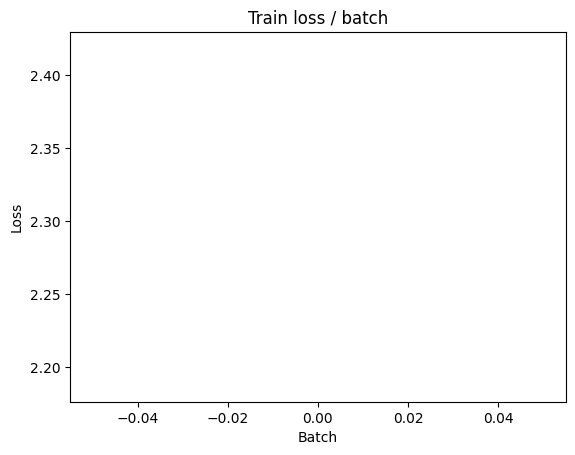

[TRAIN Batch 200/391]	Time 0.023s (0.046s)	Loss 2.2895 (2.3005)	Prec@1  12.5 ( 10.2)	Prec@5  64.1 ( 53.4)


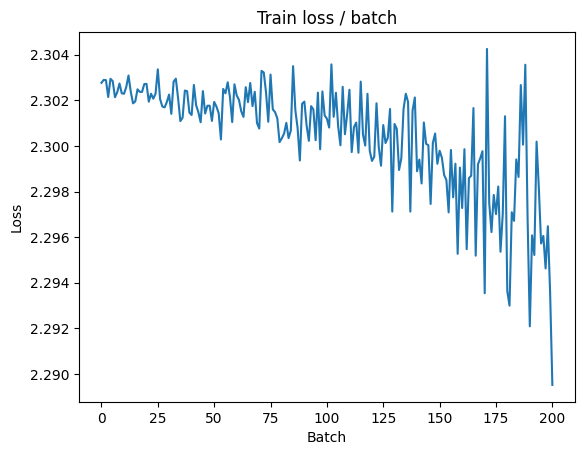


===============> Total time 13s	Avg loss 2.2627	Avg Prec@1 13.87 %	Avg Prec@5 59.42 %

[EVAL Batch 000/079]	Time 0.106s (0.106s)	Loss 2.1061 (2.1061)	Prec@1  28.1 ( 28.1)	Prec@5  78.1 ( 78.1)

===============> Total time 2s	Avg loss 2.1099	Avg Prec@1 24.26 %	Avg Prec@5 77.04 %



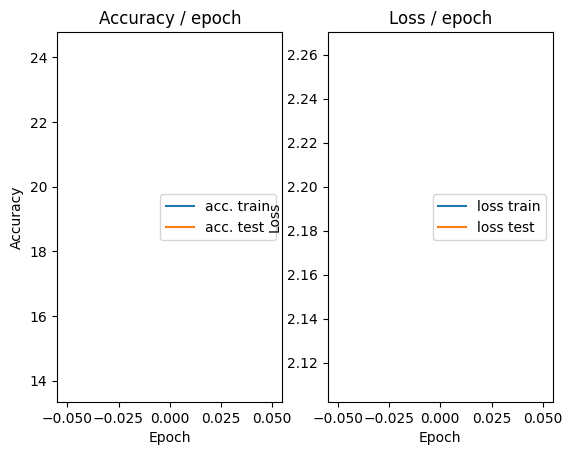

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 2.1767 (2.1767)	Prec@1  21.1 ( 21.1)	Prec@5  67.2 ( 67.2)


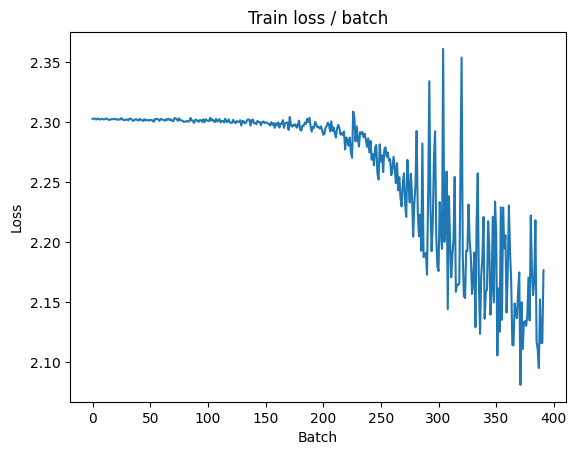

[TRAIN Batch 200/391]	Time 0.038s (0.024s)	Loss 2.0962 (2.1132)	Prec@1  30.5 ( 24.4)	Prec@5  71.9 ( 76.5)


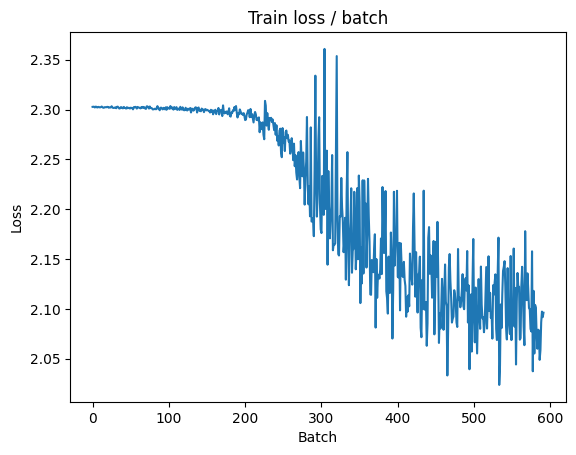


===============> Total time 8s	Avg loss 2.0998	Avg Prec@1 25.12 %	Avg Prec@5 77.85 %

[EVAL Batch 000/079]	Time 0.110s (0.110s)	Loss 2.0418 (2.0418)	Prec@1  35.9 ( 35.9)	Prec@5  82.0 ( 82.0)

===============> Total time 1s	Avg loss 2.0616	Avg Prec@1 28.50 %	Avg Prec@5 81.33 %



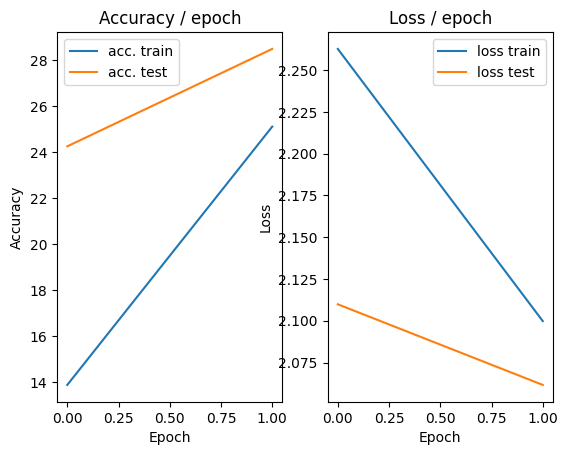

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 2.0727 (2.0727)	Prec@1  32.8 ( 32.8)	Prec@5  82.8 ( 82.8)


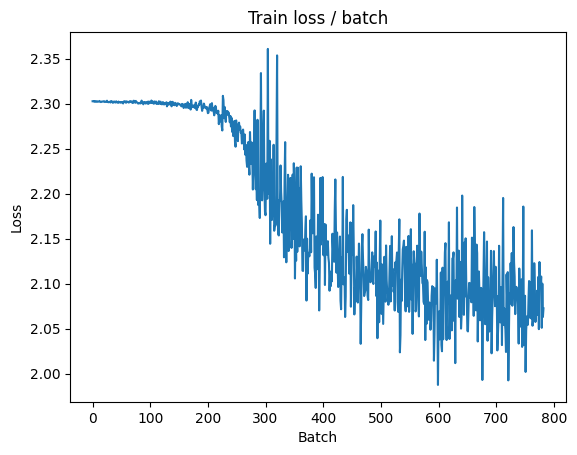

[TRAIN Batch 200/391]	Time 0.032s (0.029s)	Loss 2.0818 (2.0650)	Prec@1  36.7 ( 28.4)	Prec@5  75.0 ( 80.7)


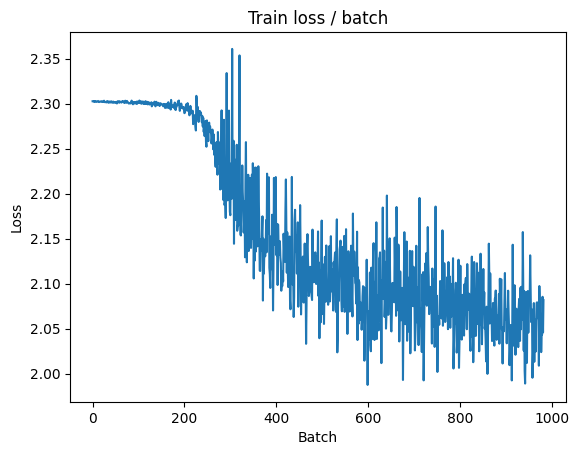


===============> Total time 10s	Avg loss 2.0520	Avg Prec@1 29.50 %	Avg Prec@5 81.88 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 2.0232 (2.0232)	Prec@1  32.8 ( 32.8)	Prec@5  82.8 ( 82.8)

===============> Total time 2s	Avg loss 2.0337	Avg Prec@1 31.45 %	Avg Prec@5 83.32 %



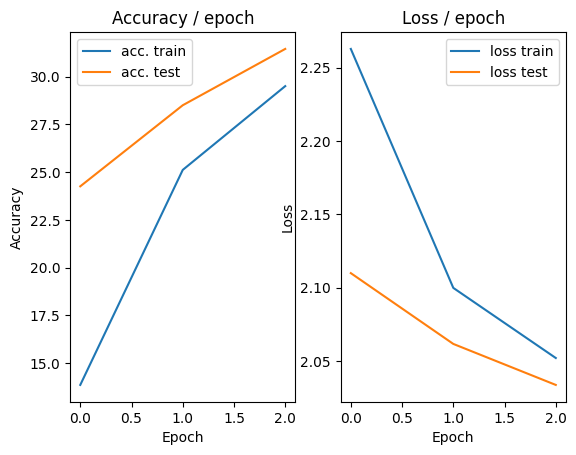

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.122s (0.122s)	Loss 2.0006 (2.0006)	Prec@1  40.6 ( 40.6)	Prec@5  85.2 ( 85.2)


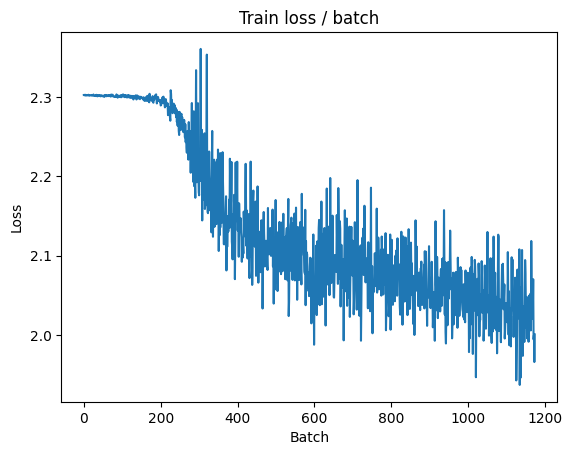

[TRAIN Batch 200/391]	Time 0.032s (0.029s)	Loss 2.0014 (2.0146)	Prec@1  30.5 ( 32.9)	Prec@5  85.9 ( 84.6)


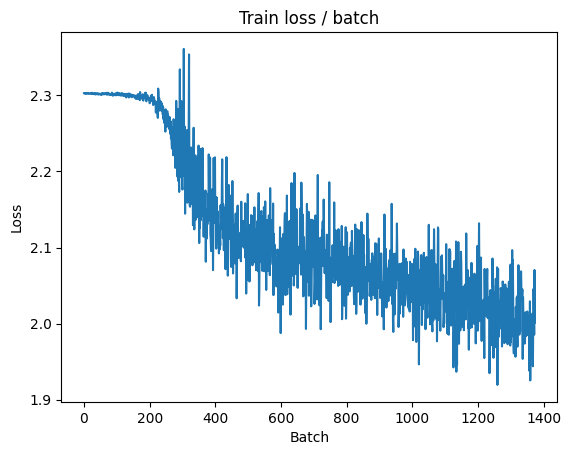


===============> Total time 9s	Avg loss 2.0040	Avg Prec@1 34.08 %	Avg Prec@5 85.25 %

[EVAL Batch 000/079]	Time 0.108s (0.108s)	Loss 1.9745 (1.9745)	Prec@1  29.7 ( 29.7)	Prec@5  88.3 ( 88.3)

===============> Total time 1s	Avg loss 1.9684	Avg Prec@1 35.58 %	Avg Prec@5 87.49 %



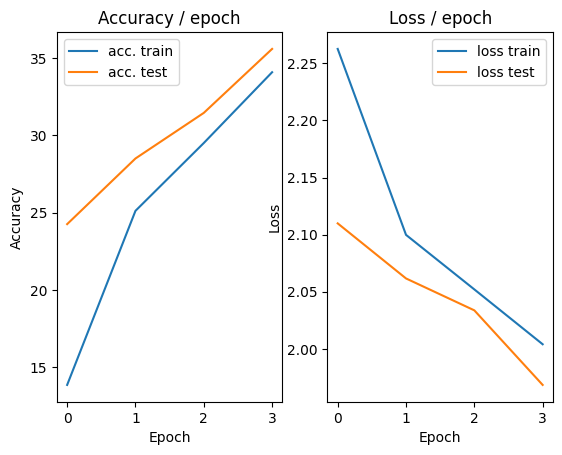

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.230s (0.230s)	Loss 1.9698 (1.9698)	Prec@1  29.7 ( 29.7)	Prec@5  89.8 ( 89.8)


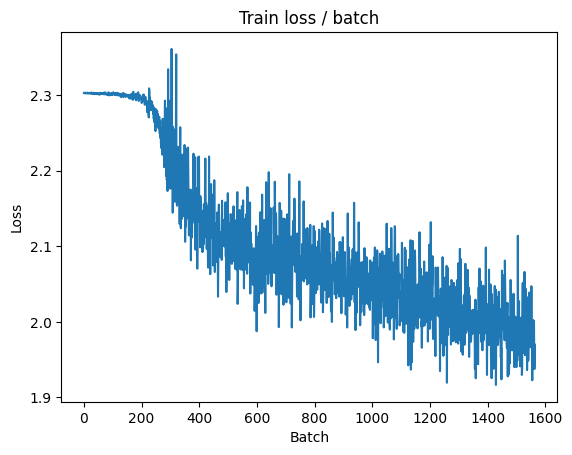

[TRAIN Batch 200/391]	Time 0.020s (0.034s)	Loss 1.8998 (1.9697)	Prec@1  43.8 ( 37.1)	Prec@5  89.8 ( 87.4)


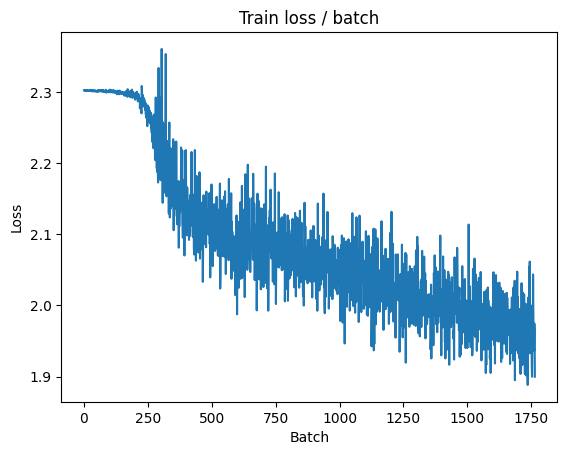


===============> Total time 11s	Avg loss 1.9625	Avg Prec@1 37.77 %	Avg Prec@5 87.88 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 1.9458 (1.9458)	Prec@1  33.6 ( 33.6)	Prec@5  89.8 ( 89.8)

===============> Total time 1s	Avg loss 1.9412	Avg Prec@1 38.15 %	Avg Prec@5 88.84 %



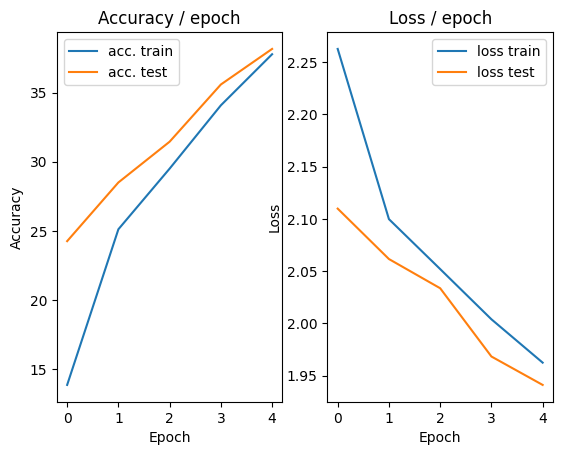

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.132s (0.132s)	Loss 2.0325 (2.0325)	Prec@1  32.8 ( 32.8)	Prec@5  81.2 ( 81.2)


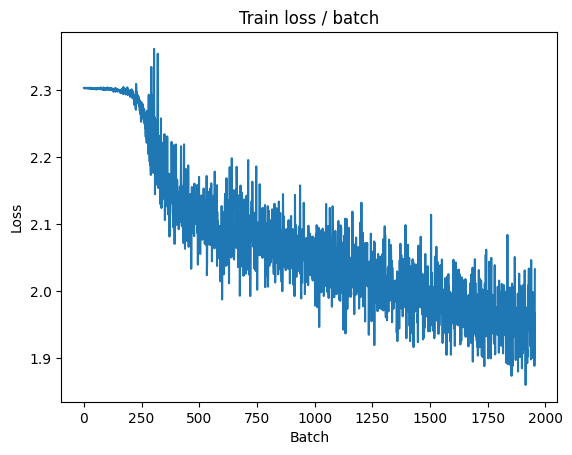

[TRAIN Batch 200/391]	Time 0.045s (0.029s)	Loss 1.9307 (1.9364)	Prec@1  39.1 ( 39.9)	Prec@5  90.6 ( 89.1)


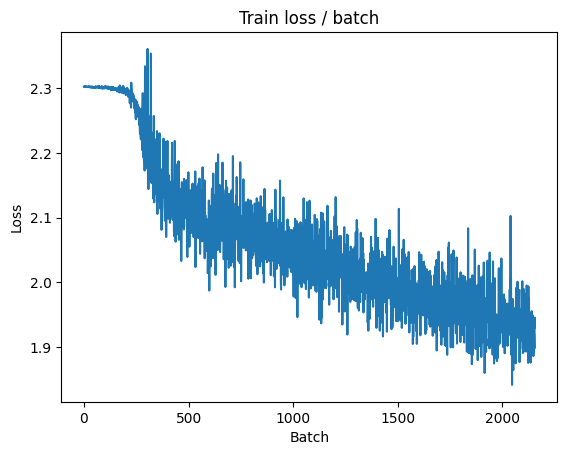


===============> Total time 9s	Avg loss 1.9320	Avg Prec@1 40.44 %	Avg Prec@5 89.45 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 1.9269 (1.9269)	Prec@1  40.6 ( 40.6)	Prec@5  89.1 ( 89.1)

===============> Total time 1s	Avg loss 1.9244	Avg Prec@1 40.44 %	Avg Prec@5 89.59 %



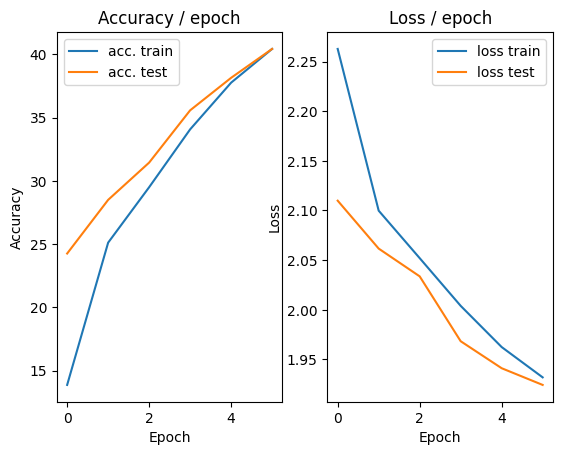

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.132s (0.132s)	Loss 1.9356 (1.9356)	Prec@1  41.4 ( 41.4)	Prec@5  89.8 ( 89.8)


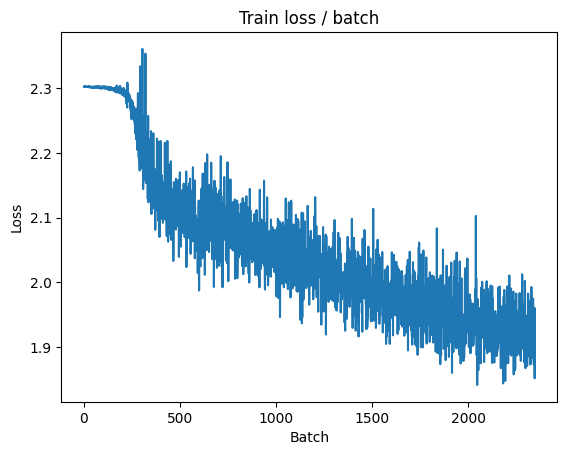

[TRAIN Batch 200/391]	Time 0.050s (0.024s)	Loss 1.8925 (1.9135)	Prec@1  43.8 ( 42.8)	Prec@5  90.6 ( 90.3)


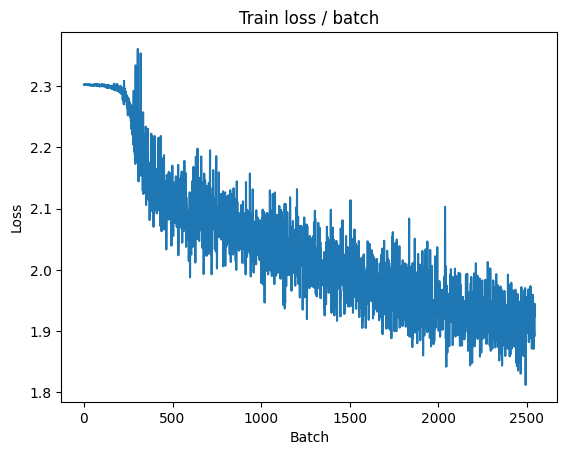


===============> Total time 9s	Avg loss 1.9081	Avg Prec@1 43.02 %	Avg Prec@5 90.78 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 1.8943 (1.8943)	Prec@1  41.4 ( 41.4)	Prec@5  90.6 ( 90.6)

===============> Total time 1s	Avg loss 1.9066	Avg Prec@1 42.87 %	Avg Prec@5 90.44 %



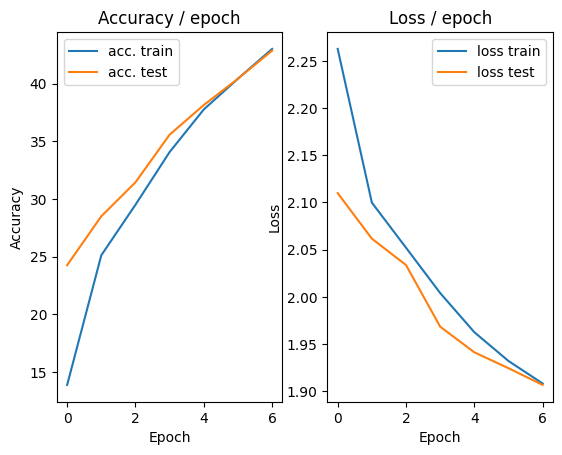

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.135s (0.135s)	Loss 1.9472 (1.9472)	Prec@1  35.9 ( 35.9)	Prec@5  88.3 ( 88.3)


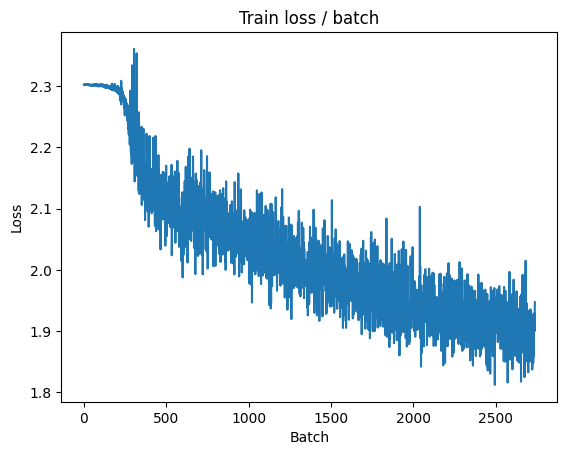

[TRAIN Batch 200/391]	Time 0.014s (0.022s)	Loss 1.8704 (1.8939)	Prec@1  50.8 ( 44.5)	Prec@5  93.0 ( 91.3)


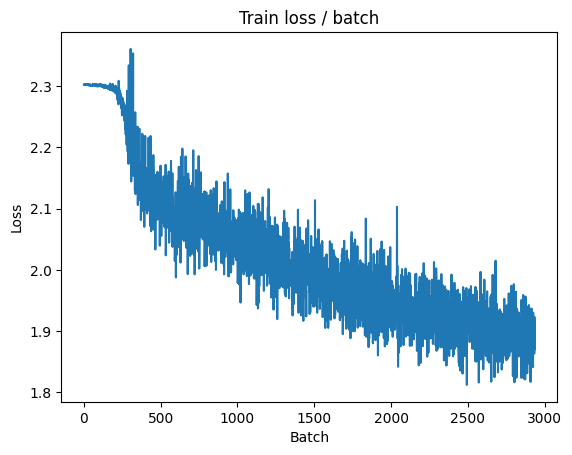


===============> Total time 9s	Avg loss 1.8902	Avg Prec@1 44.74 %	Avg Prec@5 91.42 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 1.8751 (1.8751)	Prec@1  53.1 ( 53.1)	Prec@5  91.4 ( 91.4)

===============> Total time 1s	Avg loss 1.8787	Avg Prec@1 45.46 %	Avg Prec@5 91.36 %



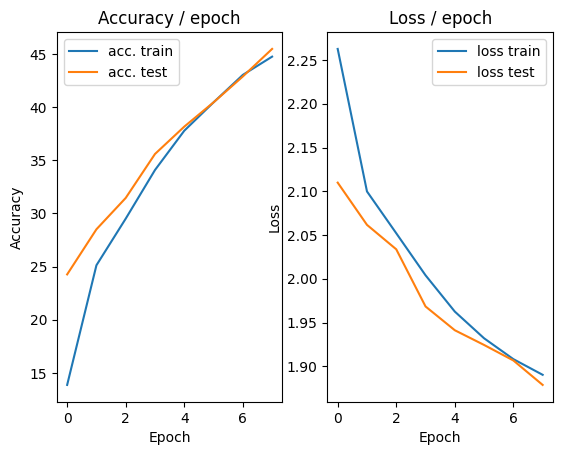

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.126s (0.126s)	Loss 1.8530 (1.8530)	Prec@1  49.2 ( 49.2)	Prec@5  93.8 ( 93.8)


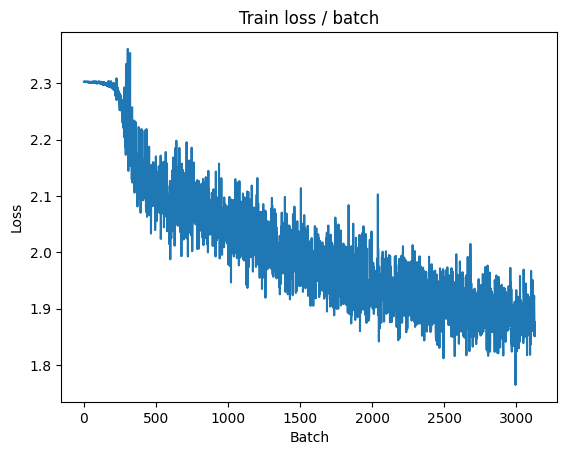

[TRAIN Batch 200/391]	Time 0.012s (0.024s)	Loss 1.8521 (1.8784)	Prec@1  50.8 ( 45.8)	Prec@5  93.0 ( 91.9)


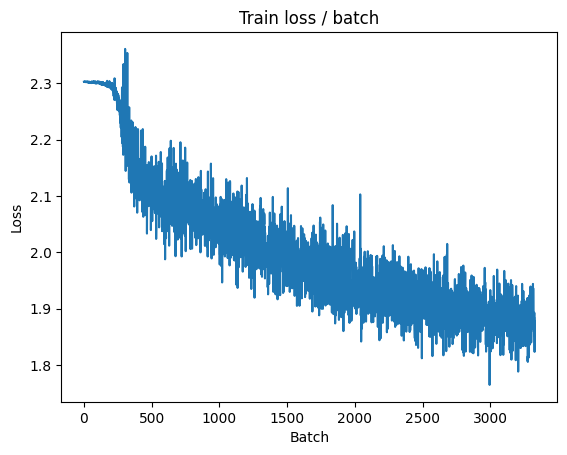


===============> Total time 10s	Avg loss 1.8760	Avg Prec@1 46.09 %	Avg Prec@5 91.95 %

[EVAL Batch 000/079]	Time 0.178s (0.178s)	Loss 1.8554 (1.8554)	Prec@1  53.1 ( 53.1)	Prec@5  92.2 ( 92.2)

===============> Total time 1s	Avg loss 1.8648	Avg Prec@1 48.17 %	Avg Prec@5 92.20 %



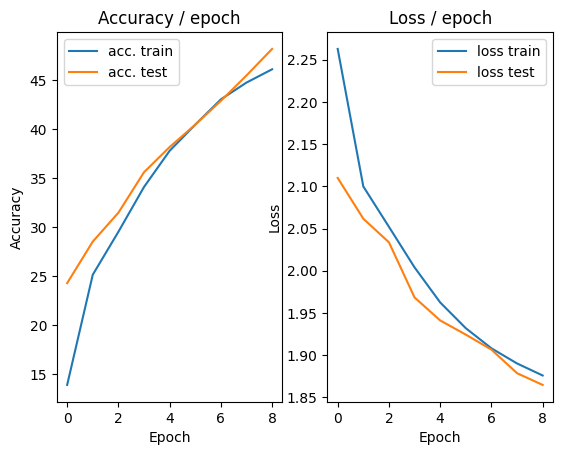

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.133s (0.133s)	Loss 1.8692 (1.8692)	Prec@1  44.5 ( 44.5)	Prec@5  94.5 ( 94.5)


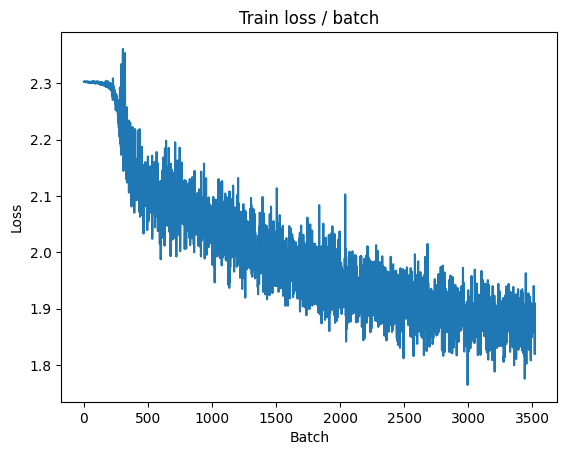

[TRAIN Batch 200/391]	Time 0.025s (0.022s)	Loss 1.8699 (1.8644)	Prec@1  52.3 ( 47.4)	Prec@5  88.3 ( 92.3)


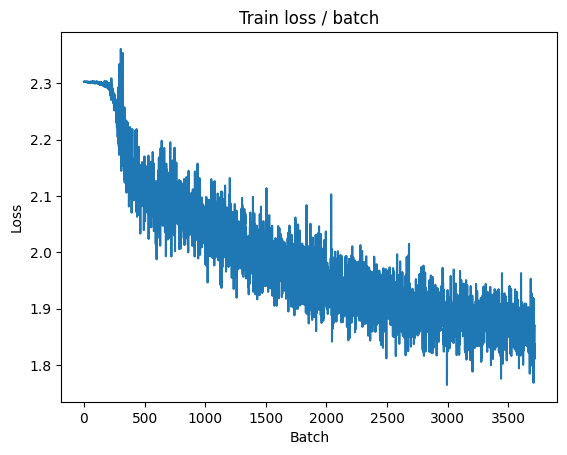


===============> Total time 8s	Avg loss 1.8637	Avg Prec@1 47.40 %	Avg Prec@5 92.29 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 1.8401 (1.8401)	Prec@1  48.4 ( 48.4)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.8709	Avg Prec@1 45.66 %	Avg Prec@5 92.36 %



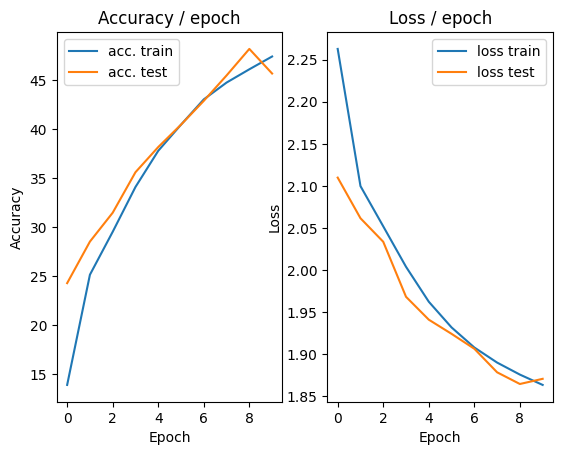

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.212s (0.212s)	Loss 1.8628 (1.8628)	Prec@1  49.2 ( 49.2)	Prec@5  96.1 ( 96.1)


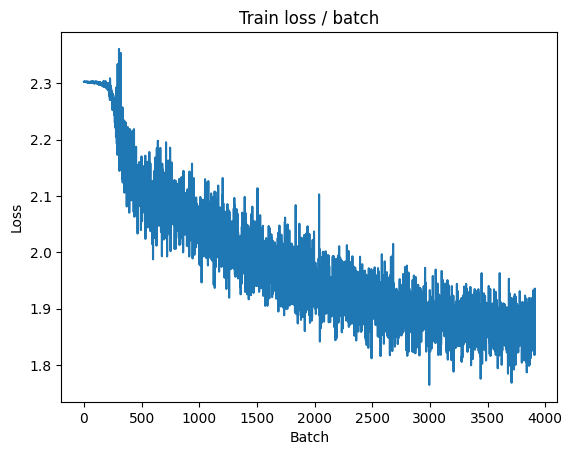

[TRAIN Batch 200/391]	Time 0.011s (0.024s)	Loss 1.8450 (1.8536)	Prec@1  40.6 ( 47.9)	Prec@5  94.5 ( 92.8)


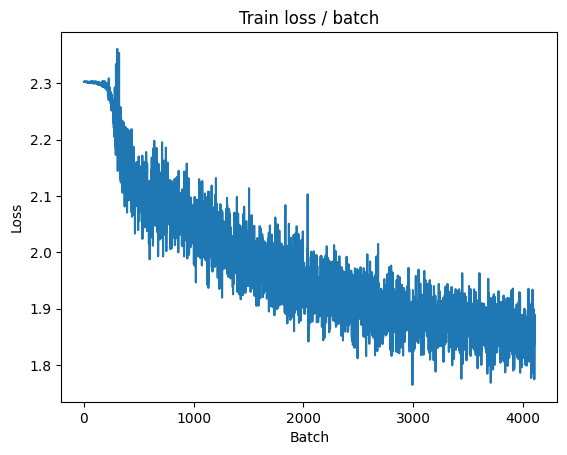


===============> Total time 9s	Avg loss 1.8538	Avg Prec@1 48.24 %	Avg Prec@5 92.79 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 1.8180 (1.8180)	Prec@1  52.3 ( 52.3)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.8436	Avg Prec@1 49.41 %	Avg Prec@5 93.25 %



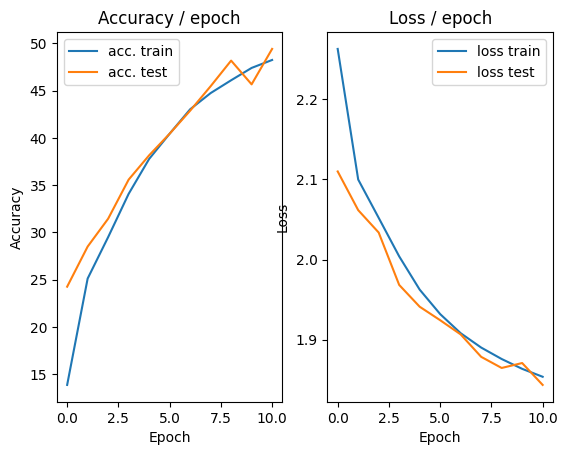

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 1.8952 (1.8952)	Prec@1  42.2 ( 42.2)	Prec@5  92.2 ( 92.2)


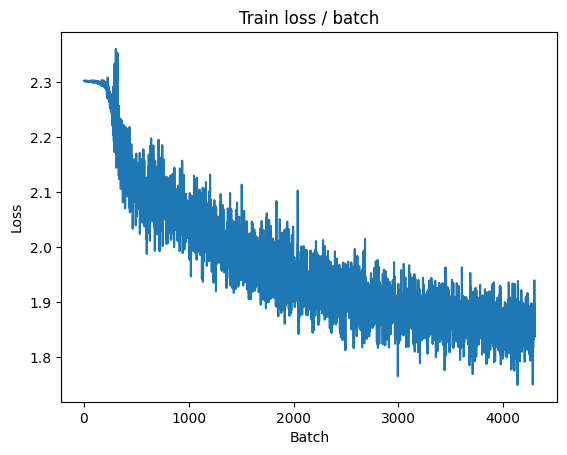

[TRAIN Batch 200/391]	Time 0.017s (0.027s)	Loss 1.8241 (1.8401)	Prec@1  49.2 ( 49.7)	Prec@5  94.5 ( 93.1)


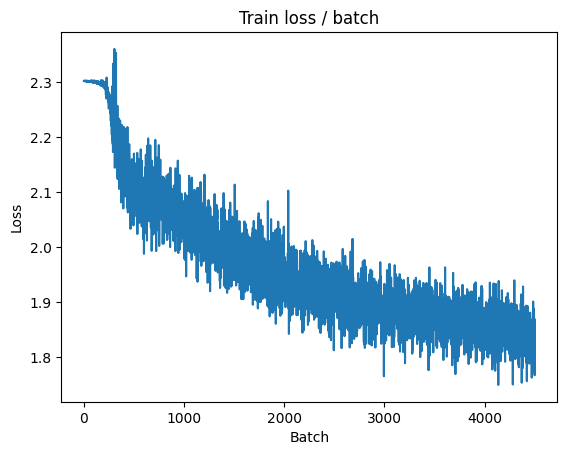


===============> Total time 9s	Avg loss 1.8413	Avg Prec@1 49.62 %	Avg Prec@5 93.08 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 1.8482 (1.8482)	Prec@1  56.2 ( 56.2)	Prec@5  93.0 ( 93.0)

===============> Total time 1s	Avg loss 1.8713	Avg Prec@1 46.64 %	Avg Prec@5 92.21 %



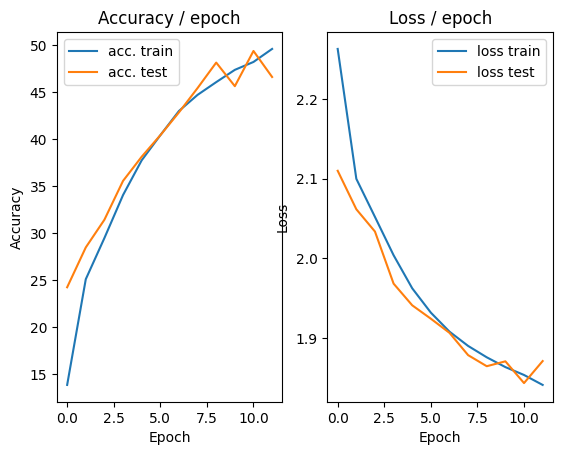

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.144s (0.144s)	Loss 1.8324 (1.8324)	Prec@1  50.8 ( 50.8)	Prec@5  94.5 ( 94.5)


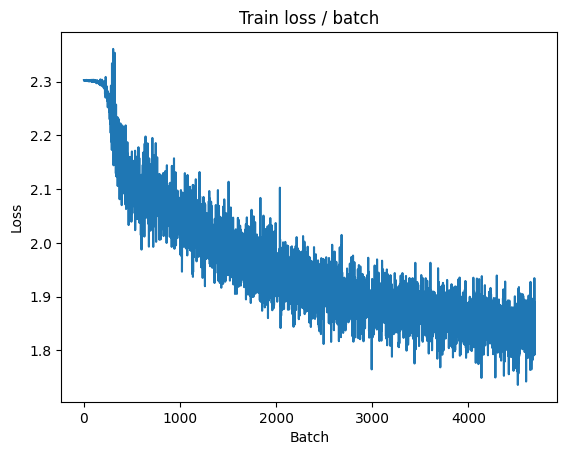

[TRAIN Batch 200/391]	Time 0.023s (0.030s)	Loss 1.8732 (1.8293)	Prec@1  46.9 ( 50.8)	Prec@5  89.1 ( 93.7)


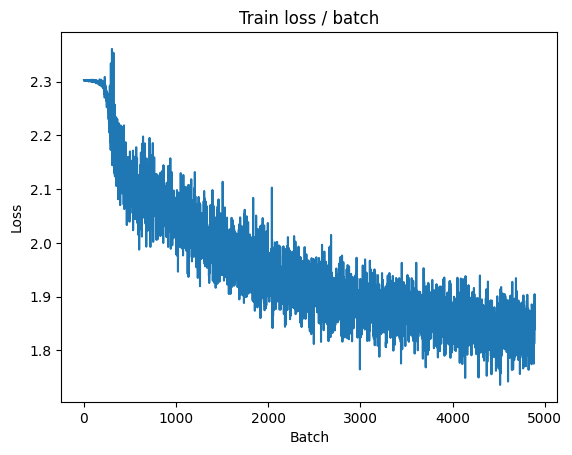


===============> Total time 10s	Avg loss 1.8304	Avg Prec@1 50.89 %	Avg Prec@5 93.69 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 1.7909 (1.7909)	Prec@1  53.9 ( 53.9)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.8339	Avg Prec@1 51.60 %	Avg Prec@5 93.66 %



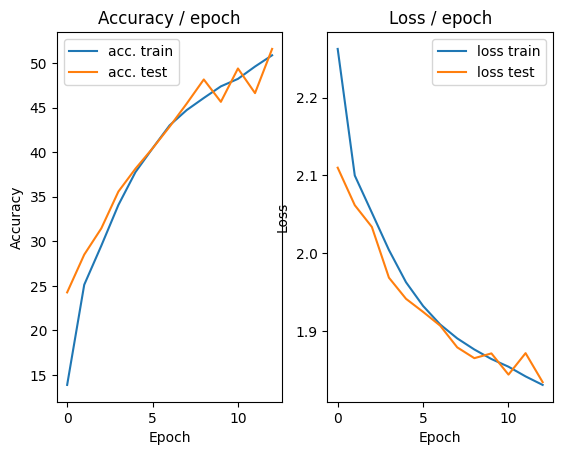

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.136s (0.136s)	Loss 1.7828 (1.7828)	Prec@1  58.6 ( 58.6)	Prec@5  96.9 ( 96.9)


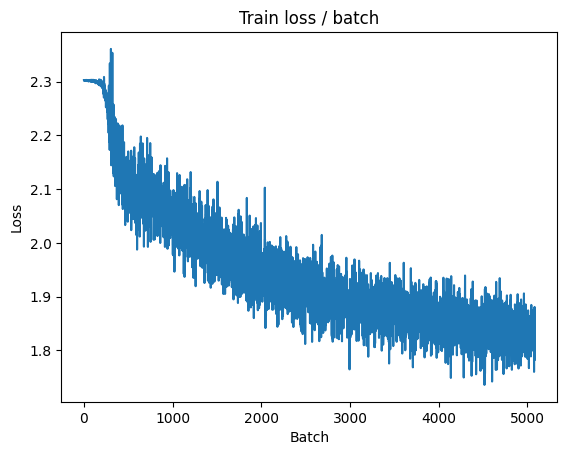

[TRAIN Batch 200/391]	Time 0.028s (0.029s)	Loss 1.8063 (1.8235)	Prec@1  47.7 ( 51.8)	Prec@5  96.1 ( 94.0)


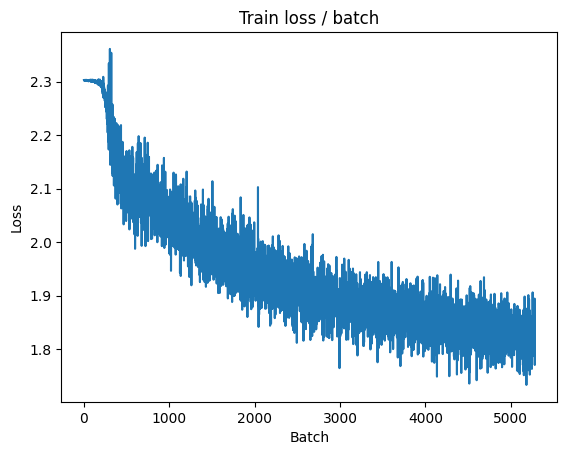


===============> Total time 10s	Avg loss 1.8197	Avg Prec@1 52.04 %	Avg Prec@5 94.05 %

[EVAL Batch 000/079]	Time 0.118s (0.118s)	Loss 1.8150 (1.8150)	Prec@1  53.1 ( 53.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.8379	Avg Prec@1 50.28 %	Avg Prec@5 93.74 %



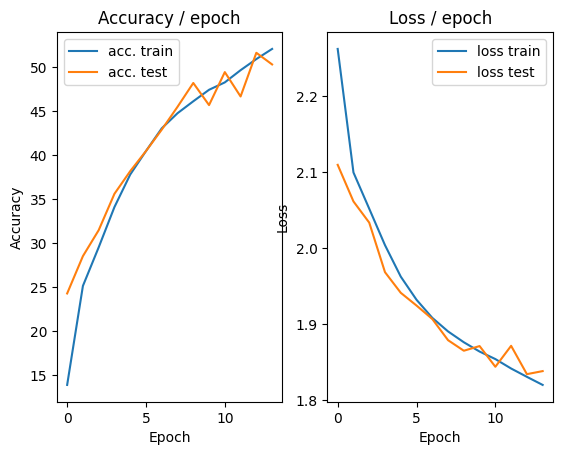

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.146s (0.146s)	Loss 1.8553 (1.8553)	Prec@1  46.9 ( 46.9)	Prec@5  92.2 ( 92.2)


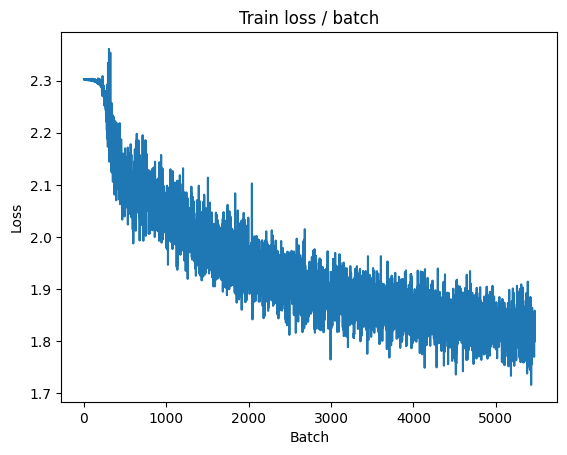

[TRAIN Batch 200/391]	Time 0.041s (0.026s)	Loss 1.8138 (1.8105)	Prec@1  50.8 ( 53.2)	Prec@5  92.2 ( 94.3)


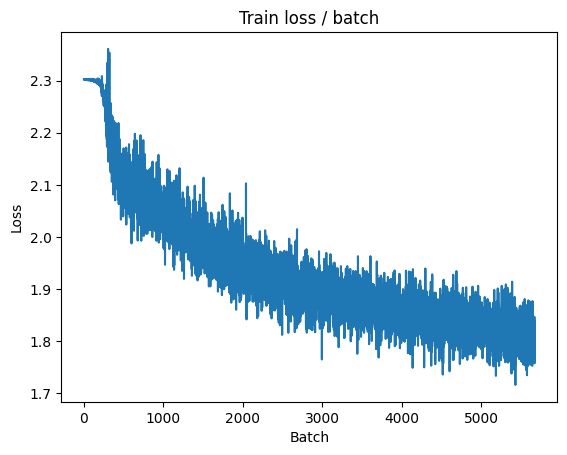


===============> Total time 9s	Avg loss 1.8106	Avg Prec@1 53.25 %	Avg Prec@5 94.31 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 1.8071 (1.8071)	Prec@1  55.5 ( 55.5)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.8284	Avg Prec@1 51.65 %	Avg Prec@5 93.80 %



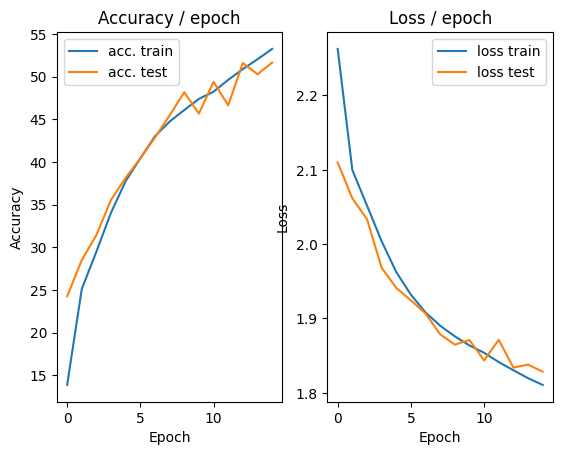

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 1.7868 (1.7868)	Prec@1  59.4 ( 59.4)	Prec@5  93.8 ( 93.8)


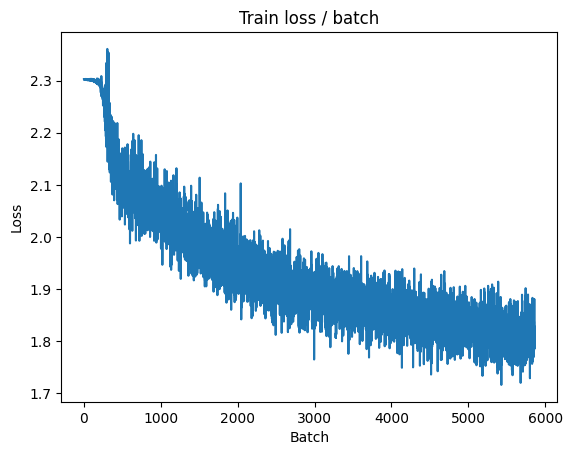

[TRAIN Batch 200/391]	Time 0.026s (0.023s)	Loss 1.8136 (1.8036)	Prec@1  53.9 ( 54.0)	Prec@5  94.5 ( 94.6)


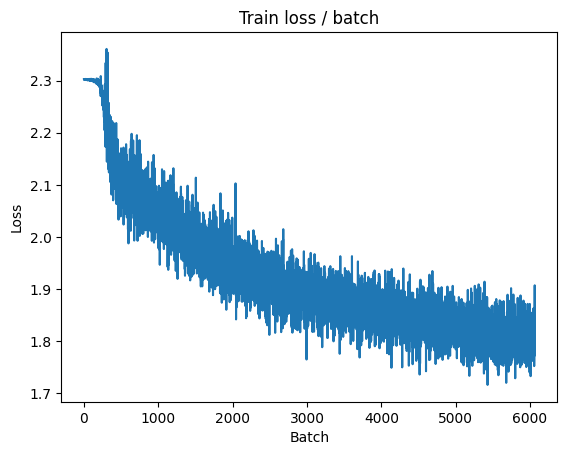


===============> Total time 10s	Avg loss 1.8016	Avg Prec@1 54.36 %	Avg Prec@5 94.57 %

[EVAL Batch 000/079]	Time 0.120s (0.120s)	Loss 1.7925 (1.7925)	Prec@1  56.2 ( 56.2)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.8400	Avg Prec@1 51.75 %	Avg Prec@5 93.12 %



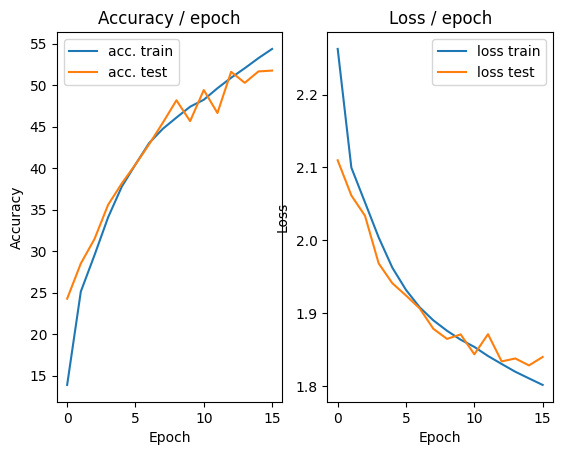

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 1.8419 (1.8419)	Prec@1  53.1 ( 53.1)	Prec@5  95.3 ( 95.3)


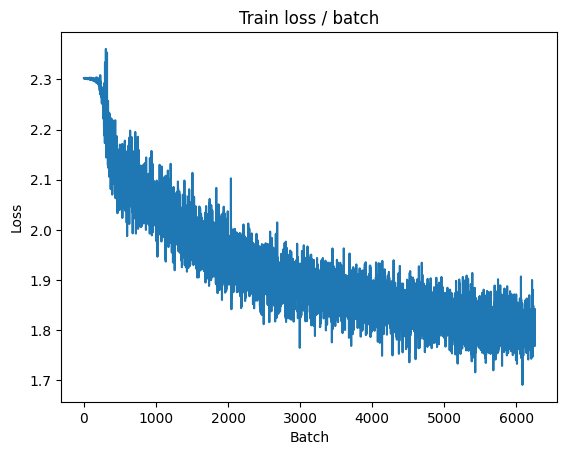

[TRAIN Batch 200/391]	Time 0.022s (0.023s)	Loss 1.8046 (1.7911)	Prec@1  57.8 ( 55.1)	Prec@5  93.8 ( 94.9)


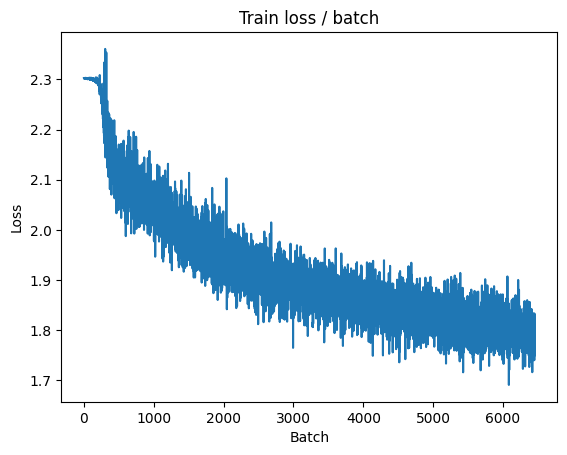


===============> Total time 10s	Avg loss 1.7911	Avg Prec@1 55.31 %	Avg Prec@5 94.96 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 1.8066 (1.8066)	Prec@1  58.6 ( 58.6)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.8248	Avg Prec@1 53.21 %	Avg Prec@5 94.04 %



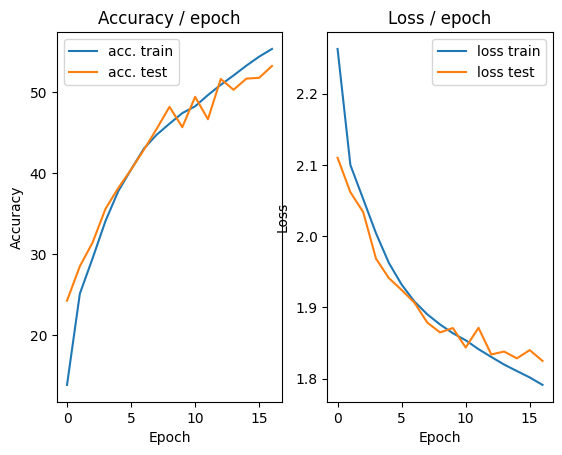

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 1.7627 (1.7627)	Prec@1  51.6 ( 51.6)	Prec@5  96.1 ( 96.1)


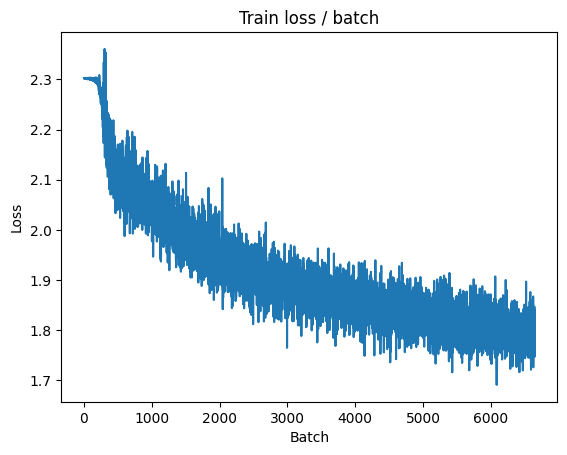

[TRAIN Batch 200/391]	Time 0.024s (0.022s)	Loss 1.7846 (1.7804)	Prec@1  53.9 ( 56.7)	Prec@5  95.3 ( 95.3)


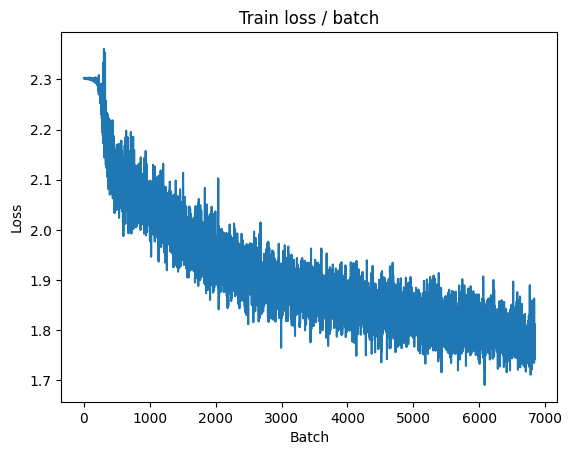


===============> Total time 10s	Avg loss 1.7815	Avg Prec@1 56.56 %	Avg Prec@5 95.24 %

[EVAL Batch 000/079]	Time 0.252s (0.252s)	Loss 1.7855 (1.7855)	Prec@1  58.6 ( 58.6)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.8200	Avg Prec@1 52.32 %	Avg Prec@5 94.55 %



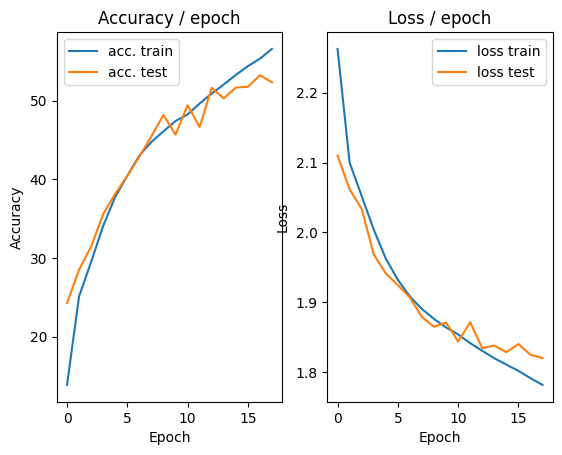

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 1.7726 (1.7726)	Prec@1  57.0 ( 57.0)	Prec@5  96.1 ( 96.1)


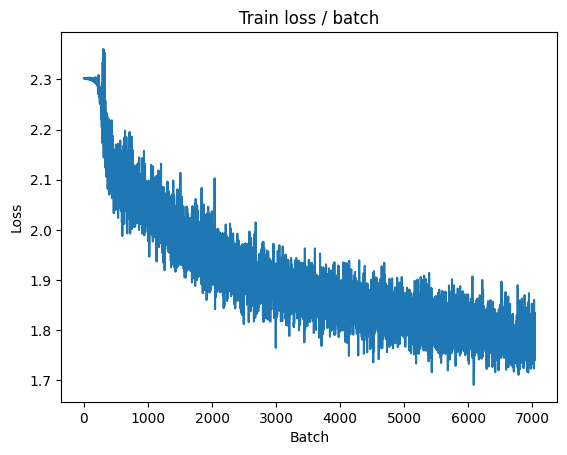

[TRAIN Batch 200/391]	Time 0.029s (0.023s)	Loss 1.8352 (1.7744)	Prec@1  53.9 ( 56.7)	Prec@5  91.4 ( 95.1)


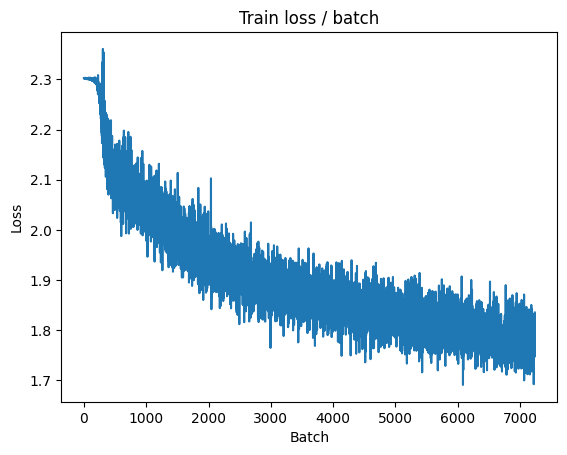


===============> Total time 9s	Avg loss 1.7727	Avg Prec@1 56.99 %	Avg Prec@5 95.29 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 1.7695 (1.7695)	Prec@1  57.8 ( 57.8)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.7966	Avg Prec@1 56.04 %	Avg Prec@5 95.20 %



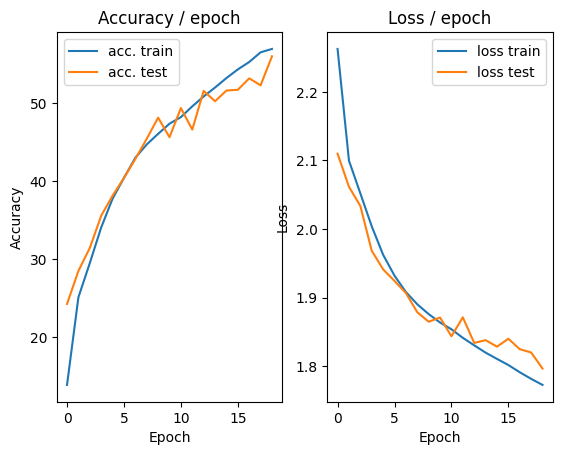

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.144s (0.144s)	Loss 1.7519 (1.7519)	Prec@1  60.2 ( 60.2)	Prec@5  96.1 ( 96.1)


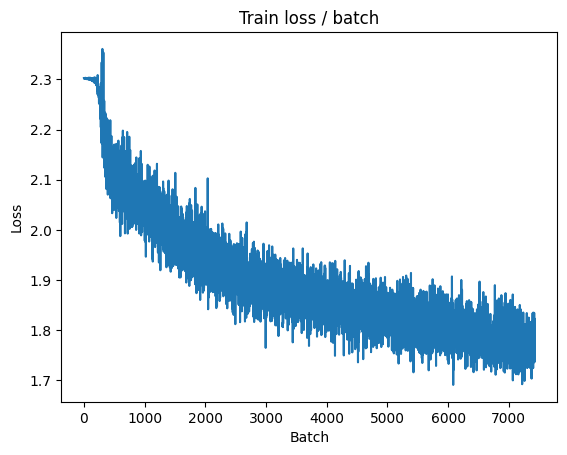

[TRAIN Batch 200/391]	Time 0.044s (0.023s)	Loss 1.7896 (1.7642)	Prec@1  55.5 ( 58.4)	Prec@5  94.5 ( 95.5)


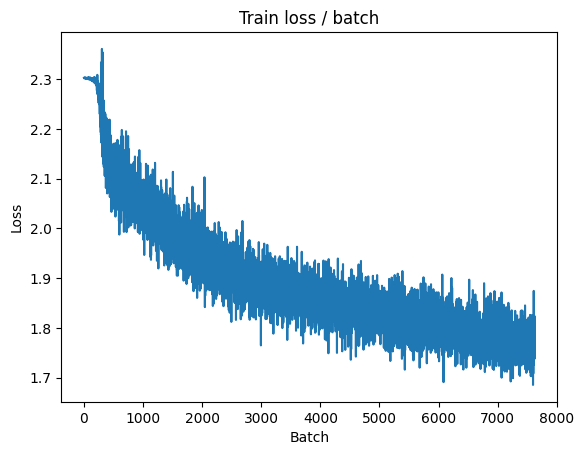


===============> Total time 8s	Avg loss 1.7654	Avg Prec@1 58.29 %	Avg Prec@5 95.48 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.7639 (1.7639)	Prec@1  62.5 ( 62.5)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.7983	Avg Prec@1 56.07 %	Avg Prec@5 95.10 %



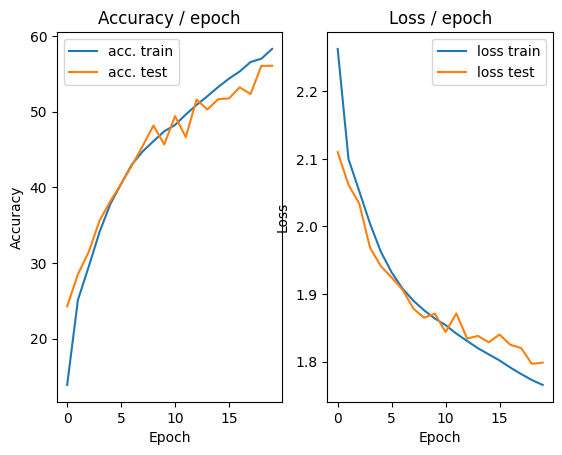

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.199s (0.199s)	Loss 1.7570 (1.7570)	Prec@1  57.0 ( 57.0)	Prec@5  96.1 ( 96.1)


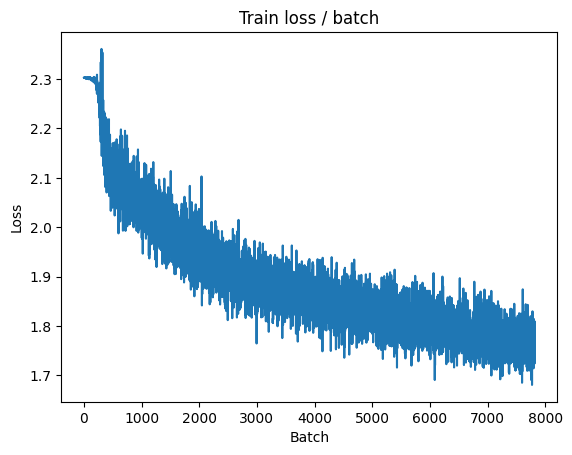

[TRAIN Batch 200/391]	Time 0.009s (0.026s)	Loss 1.7887 (1.7574)	Prec@1  54.7 ( 59.1)	Prec@5  93.8 ( 95.7)


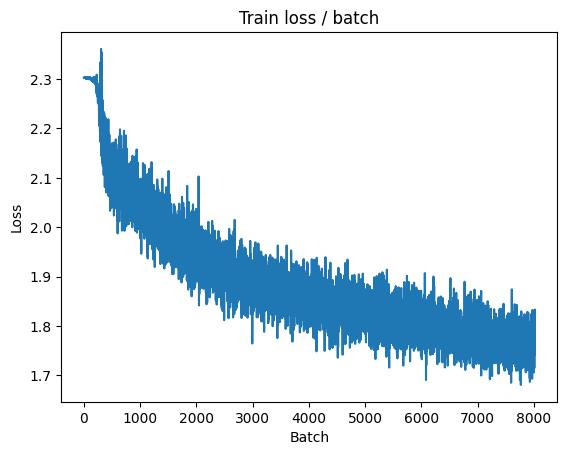


===============> Total time 9s	Avg loss 1.7568	Avg Prec@1 59.10 %	Avg Prec@5 95.73 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 1.7518 (1.7518)	Prec@1  60.9 ( 60.9)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.8023	Avg Prec@1 55.22 %	Avg Prec@5 95.01 %



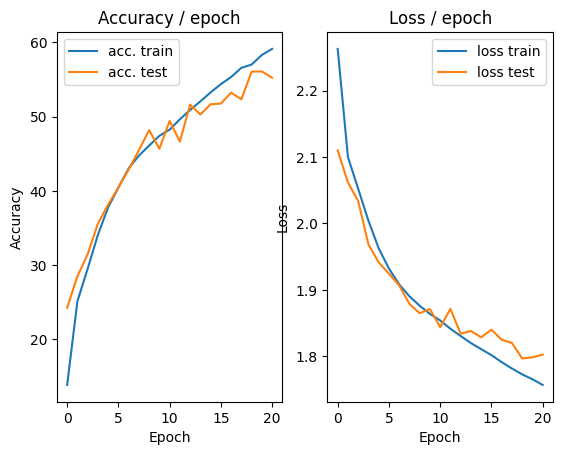

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.157s (0.157s)	Loss 1.7730 (1.7730)	Prec@1  52.3 ( 52.3)	Prec@5  93.8 ( 93.8)


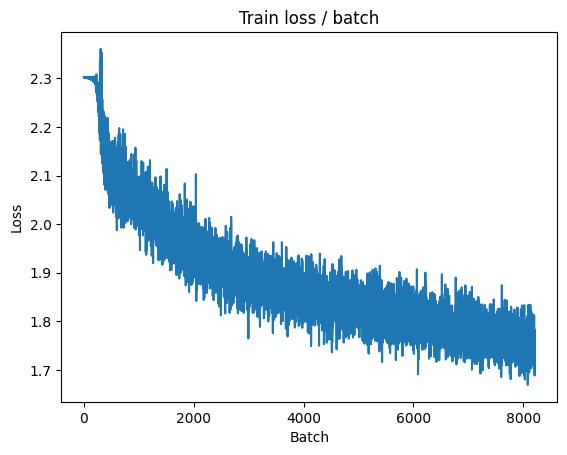

[TRAIN Batch 200/391]	Time 0.013s (0.030s)	Loss 1.7312 (1.7478)	Prec@1  59.4 ( 59.9)	Prec@5  95.3 ( 95.9)


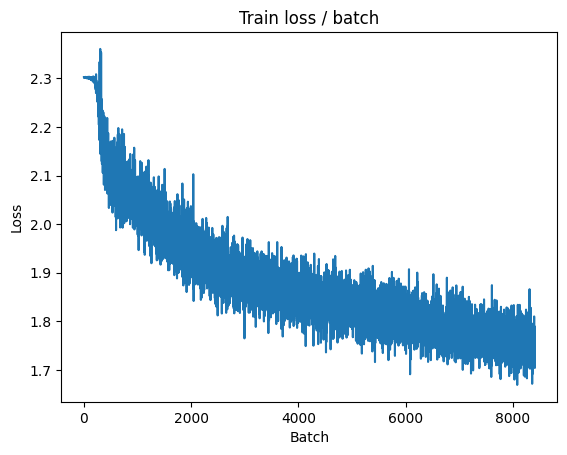


===============> Total time 10s	Avg loss 1.7475	Avg Prec@1 60.04 %	Avg Prec@5 95.89 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 1.7474 (1.7474)	Prec@1  63.3 ( 63.3)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.7918	Avg Prec@1 56.74 %	Avg Prec@5 95.09 %



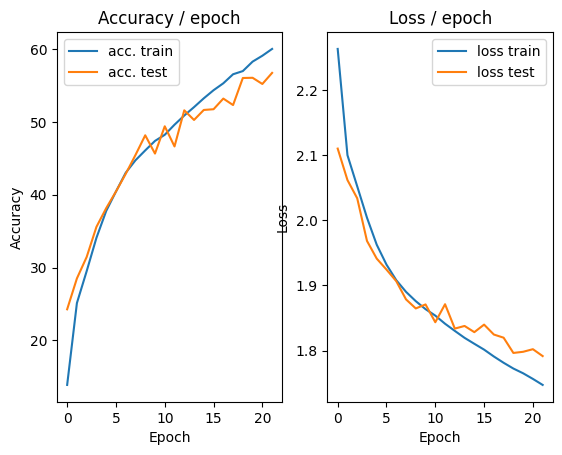

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 1.7719 (1.7719)	Prec@1  57.8 ( 57.8)	Prec@5  93.8 ( 93.8)


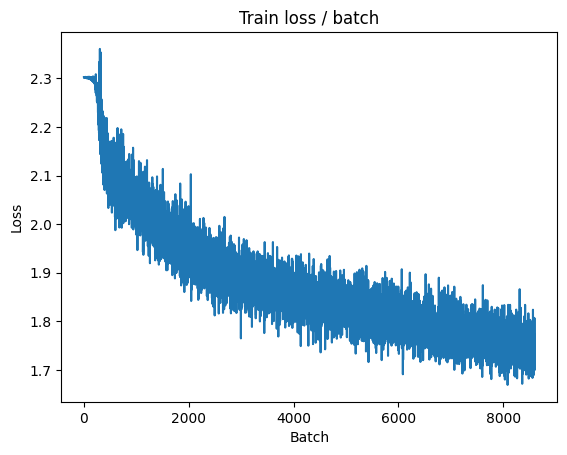

[TRAIN Batch 200/391]	Time 0.018s (0.029s)	Loss 1.7794 (1.7379)	Prec@1  60.2 ( 61.1)	Prec@5  95.3 ( 96.3)


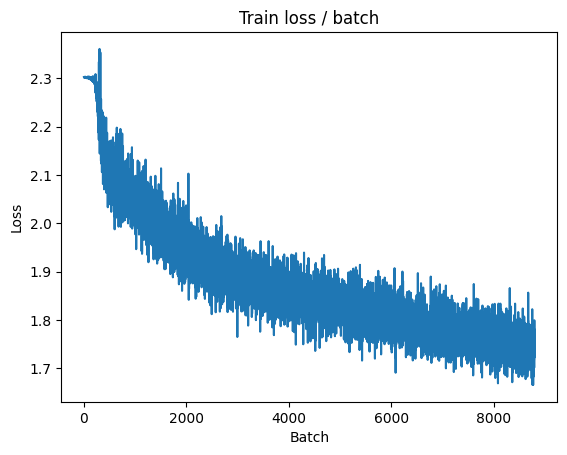


===============> Total time 10s	Avg loss 1.7394	Avg Prec@1 60.98 %	Avg Prec@5 96.06 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 1.7700 (1.7700)	Prec@1  60.9 ( 60.9)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.7874	Avg Prec@1 56.59 %	Avg Prec@5 95.39 %



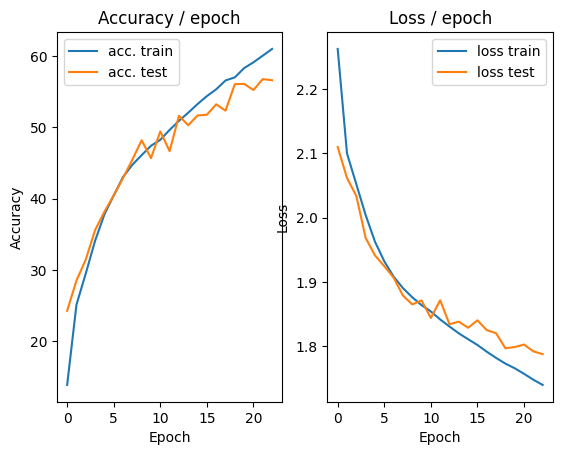

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.177s (0.177s)	Loss 1.7380 (1.7380)	Prec@1  63.3 ( 63.3)	Prec@5  95.3 ( 95.3)


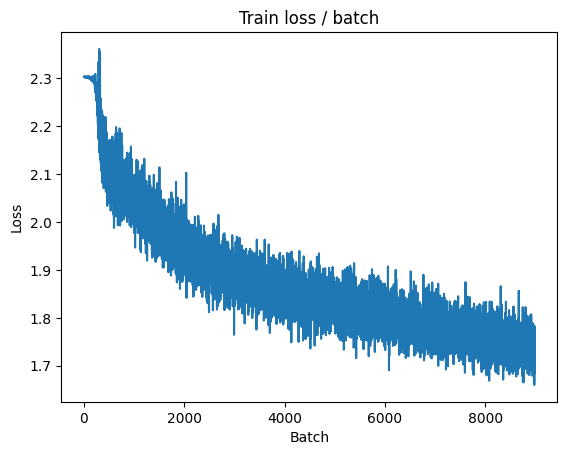

[TRAIN Batch 200/391]	Time 0.017s (0.026s)	Loss 1.7278 (1.7316)	Prec@1  58.6 ( 62.1)	Prec@5  96.9 ( 96.2)


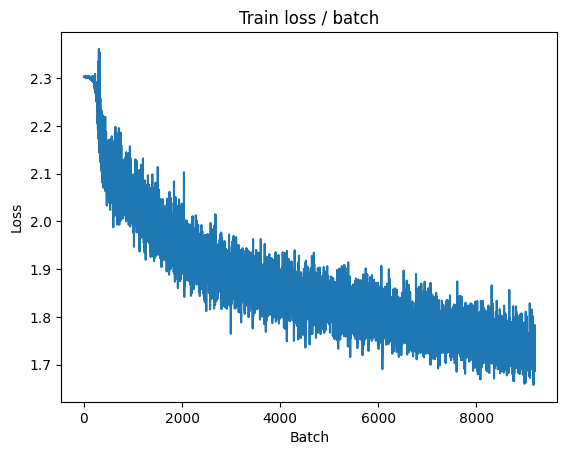


===============> Total time 10s	Avg loss 1.7311	Avg Prec@1 62.17 %	Avg Prec@5 96.20 %

[EVAL Batch 000/079]	Time 0.126s (0.126s)	Loss 1.7394 (1.7394)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.7874	Avg Prec@1 56.45 %	Avg Prec@5 95.53 %



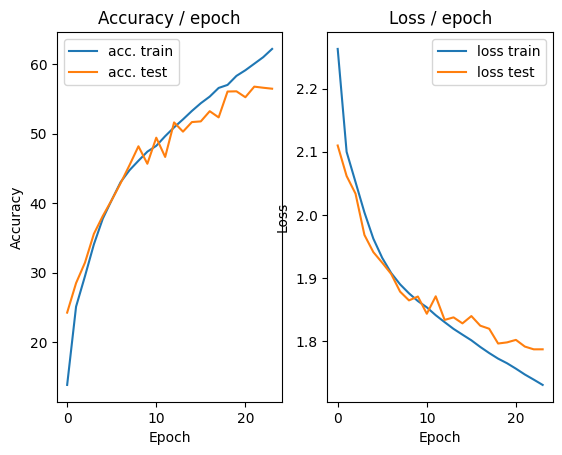

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 1.7470 (1.7470)	Prec@1  61.7 ( 61.7)	Prec@5  93.0 ( 93.0)


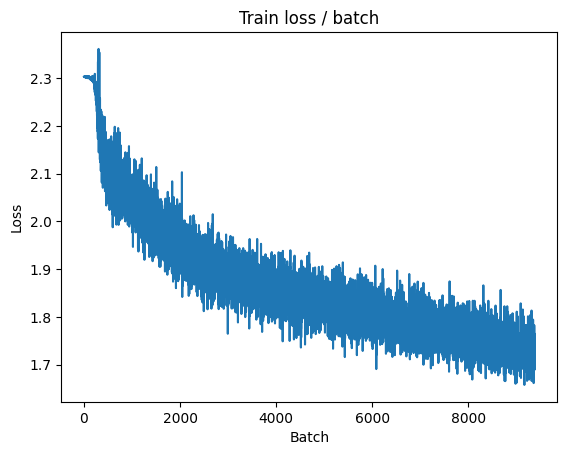

[TRAIN Batch 200/391]	Time 0.013s (0.023s)	Loss 1.6907 (1.7212)	Prec@1  64.8 ( 63.6)	Prec@5  97.7 ( 96.2)


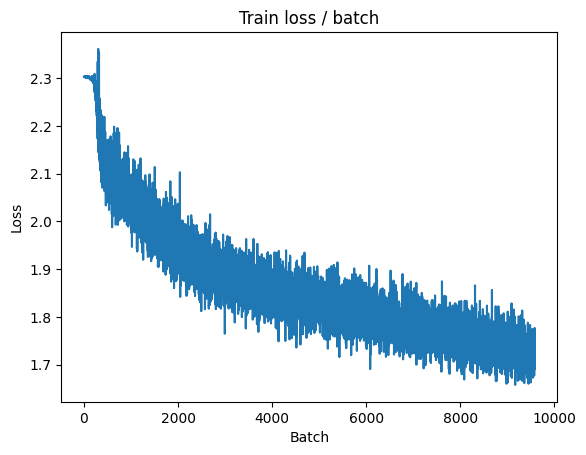


===============> Total time 10s	Avg loss 1.7236	Avg Prec@1 63.20 %	Avg Prec@5 96.21 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 1.7534 (1.7534)	Prec@1  64.8 ( 64.8)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.7748	Avg Prec@1 58.70 %	Avg Prec@5 95.72 %



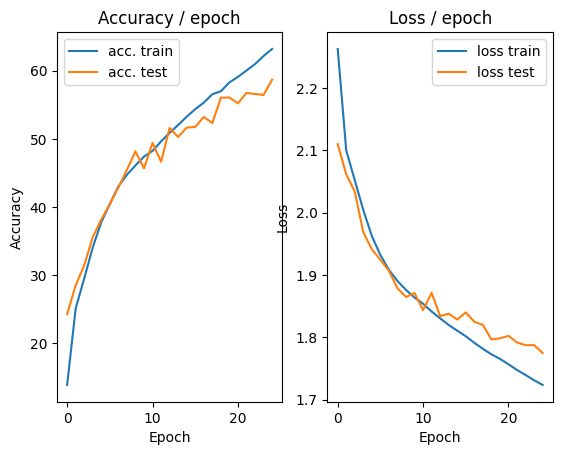

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 1.6950 (1.6950)	Prec@1  60.9 ( 60.9)	Prec@5  97.7 ( 97.7)


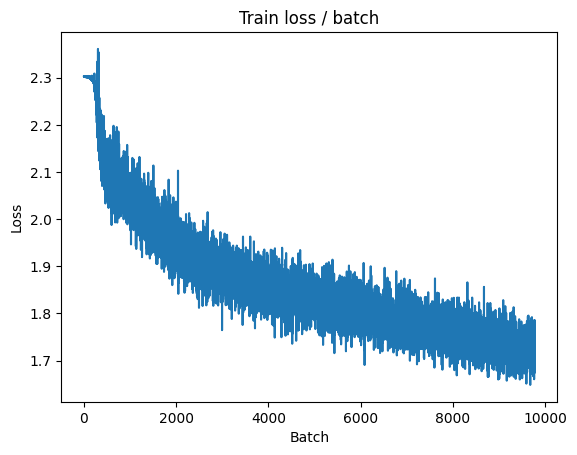

[TRAIN Batch 200/391]	Time 0.021s (0.023s)	Loss 1.7372 (1.7189)	Prec@1  53.1 ( 63.8)	Prec@5  95.3 ( 96.3)


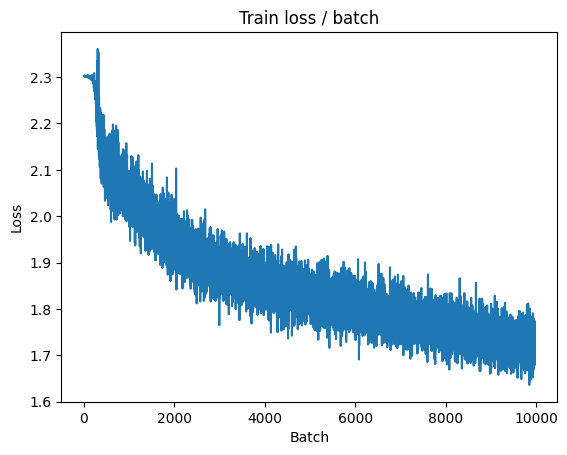


===============> Total time 10s	Avg loss 1.7157	Avg Prec@1 64.05 %	Avg Prec@5 96.42 %

[EVAL Batch 000/079]	Time 0.126s (0.126s)	Loss 1.7489 (1.7489)	Prec@1  65.6 ( 65.6)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.7860	Avg Prec@1 57.70 %	Avg Prec@5 94.90 %



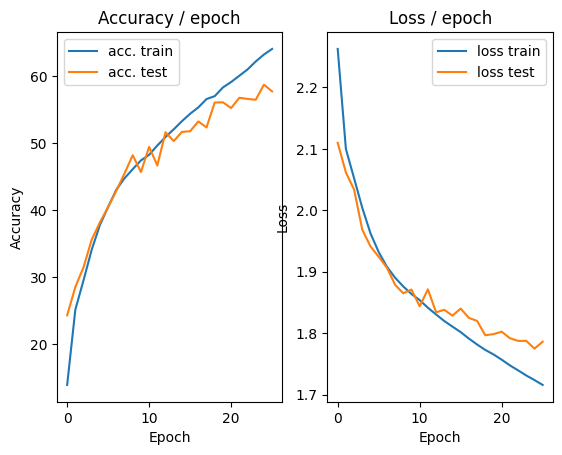

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.173s (0.173s)	Loss 1.6975 (1.6975)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)


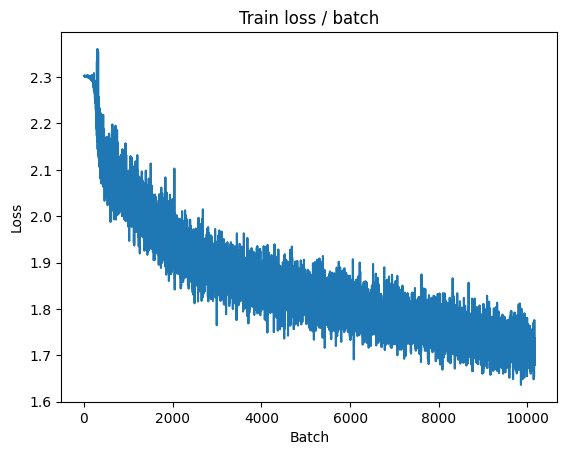

[TRAIN Batch 200/391]	Time 0.015s (0.024s)	Loss 1.7087 (1.7074)	Prec@1  66.4 ( 64.9)	Prec@5  98.4 ( 96.3)


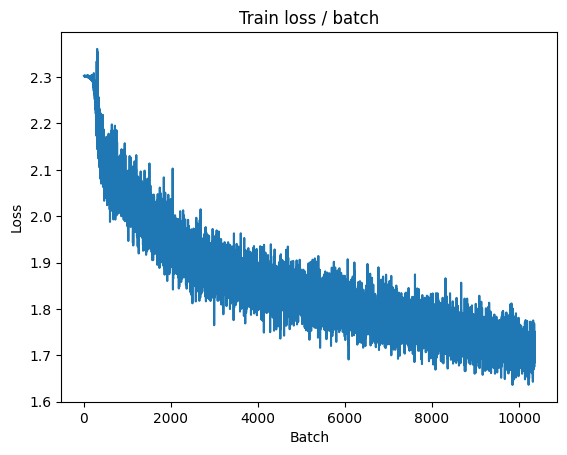


===============> Total time 9s	Avg loss 1.7079	Avg Prec@1 64.87 %	Avg Prec@5 96.39 %

[EVAL Batch 000/079]	Time 0.200s (0.200s)	Loss 1.7660 (1.7660)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.7864	Avg Prec@1 58.11 %	Avg Prec@5 95.24 %



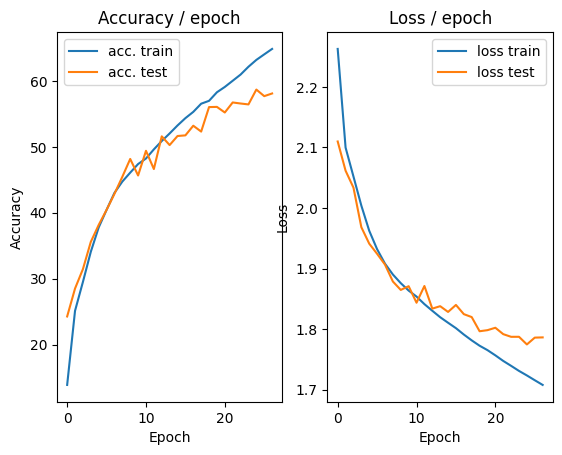

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 1.7024 (1.7024)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)


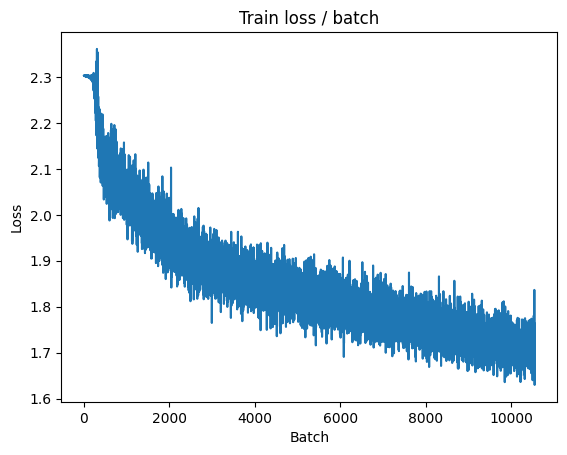

[TRAIN Batch 200/391]	Time 0.012s (0.023s)	Loss 1.7301 (1.6991)	Prec@1  66.4 ( 66.0)	Prec@5  96.9 ( 96.5)


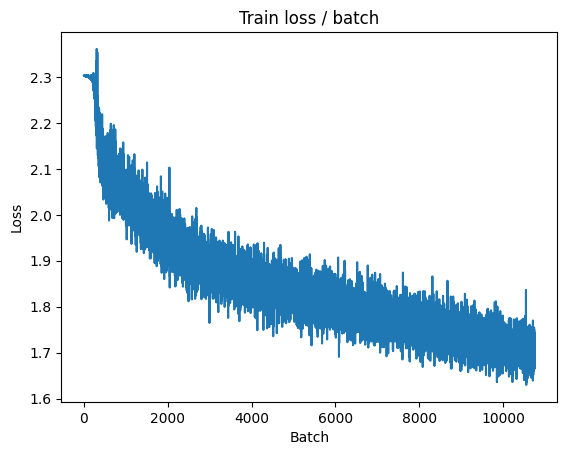


===============> Total time 8s	Avg loss 1.7005	Avg Prec@1 65.78 %	Avg Prec@5 96.59 %

[EVAL Batch 000/079]	Time 0.204s (0.204s)	Loss 1.7235 (1.7235)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.7670	Avg Prec@1 60.69 %	Avg Prec@5 95.59 %



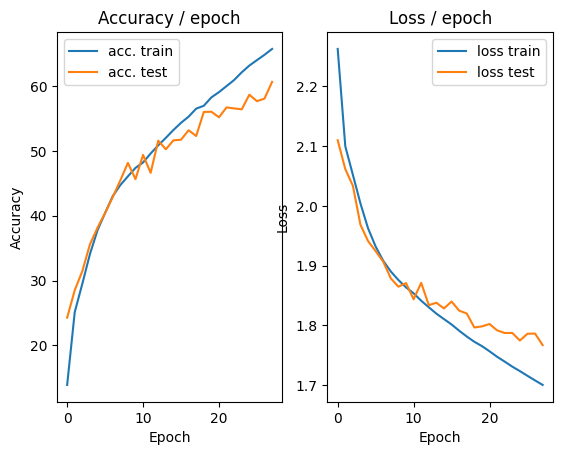

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.234s (0.234s)	Loss 1.6875 (1.6875)	Prec@1  65.6 ( 65.6)	Prec@5  96.9 ( 96.9)


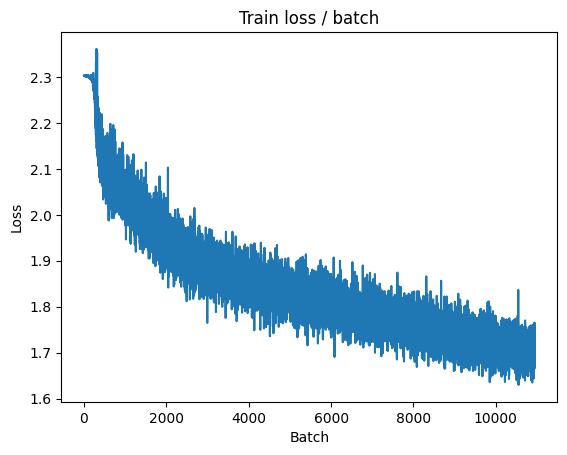

[TRAIN Batch 200/391]	Time 0.009s (0.024s)	Loss 1.6955 (1.6906)	Prec@1  59.4 ( 66.7)	Prec@5  97.7 ( 96.7)


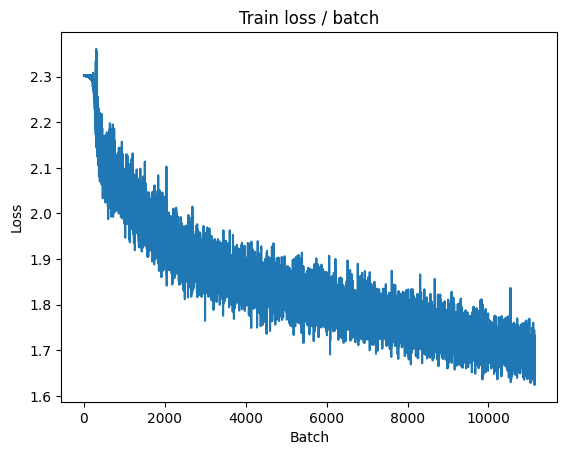


===============> Total time 9s	Avg loss 1.6912	Avg Prec@1 66.81 %	Avg Prec@5 96.68 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.7274 (1.7274)	Prec@1  64.8 ( 64.8)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.7703	Avg Prec@1 60.25 %	Avg Prec@5 95.87 %



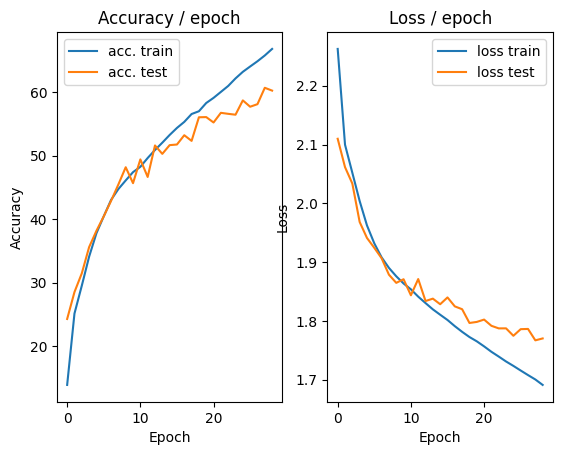

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.233s (0.233s)	Loss 1.6720 (1.6720)	Prec@1  70.3 ( 70.3)	Prec@5  98.4 ( 98.4)


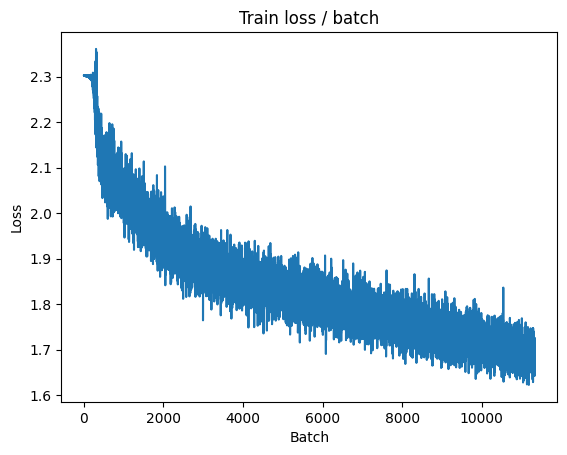

[TRAIN Batch 200/391]	Time 0.032s (0.028s)	Loss 1.6866 (1.6831)	Prec@1  68.8 ( 67.6)	Prec@5  96.1 ( 96.8)


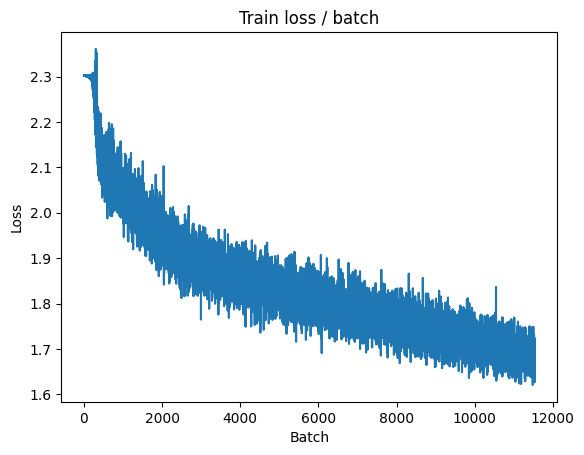


===============> Total time 9s	Avg loss 1.6855	Avg Prec@1 67.42 %	Avg Prec@5 96.77 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 1.7422 (1.7422)	Prec@1  65.6 ( 65.6)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.7927	Avg Prec@1 57.63 %	Avg Prec@5 94.83 %



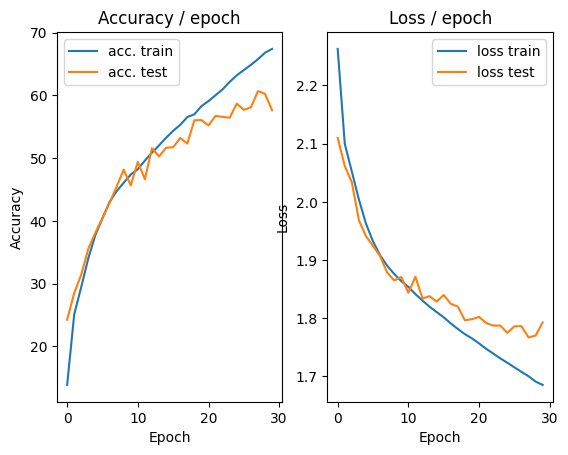

In [ ]:
main(128, 0.1, epochs=30, cuda=True)

# Trial 1: My first attempt (to remain a free deep learner) !

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output



def get_dataset(batch_size, cuda=False):

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    test_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    ######################
    ### YOUR CODE HERE ###
    ######################

    # Find a way to split off a val set from the train set (you can use SubsetRandomSampler)

    train_loader = None
    val_loader = None
    test_loader = None

    return train_loader, val_loader, test_loader

    ######################
    ###       END      ###
    ######################


def epoch(data, model, criterion, optimizer=None, cuda=False):

    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, val, test = get_dataset(batch_size, cuda)

    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()


    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")

        ######################
        ### YOUR CODE HERE ###
        ######################

        plot.update(loss.avg, loss_val.avg, top1_acc.avg, top1_acc_val.avg)
    print("Final perfomance is {}".format(top1_acc_test))



Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/352]	Time 0.264s (0.264s)	Loss 2.3021 (2.3021)	Prec@1   7.0 (  7.0)	Prec@5  50.0 ( 50.0)


<Figure size 640x480 with 0 Axes>

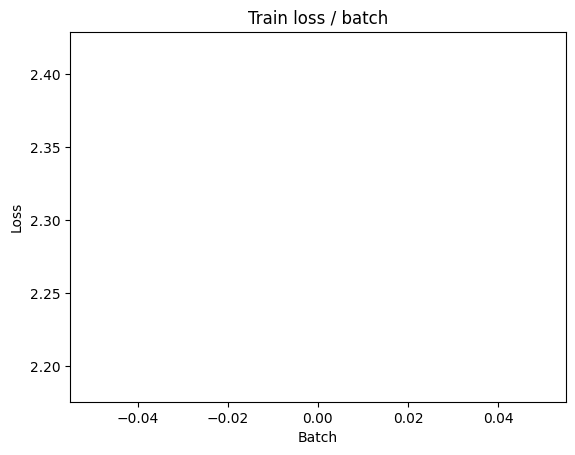

[TRAIN Batch 200/352]	Time 0.014s (0.027s)	Loss 2.1332 (2.2521)	Prec@1  21.1 ( 14.6)	Prec@5  67.2 ( 60.4)


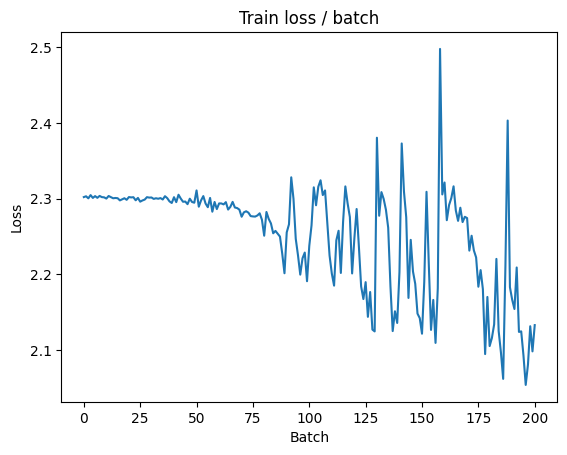


===============> Total time 8s	Avg loss 2.1742	Avg Prec@1 19.07 %	Avg Prec@5 66.92 %

[EVAL Batch 000/040]	Time 0.153s (0.153s)	Loss 2.0536 (2.0536)	Prec@1  29.7 ( 29.7)	Prec@5  82.8 ( 82.8)

===============> Total time 0s	Avg loss 2.1196	Avg Prec@1 24.75 %	Avg Prec@5 72.54 %

[EVAL Batch 000/079]	Time 0.105s (0.105s)	Loss 2.1557 (2.1557)	Prec@1  20.3 ( 20.3)	Prec@5  67.2 ( 67.2)

===============> Total time 1s	Avg loss 2.1222	Avg Prec@1 25.57 %	Avg Prec@5 71.53 %



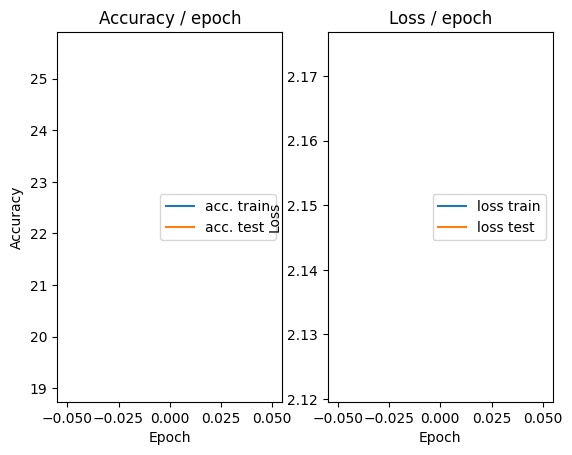

=== EPOCH 2 =====

[TRAIN Batch 000/352]	Time 0.207s (0.207s)	Loss 2.1666 (2.1666)	Prec@1  17.2 ( 17.2)	Prec@5  68.0 ( 68.0)


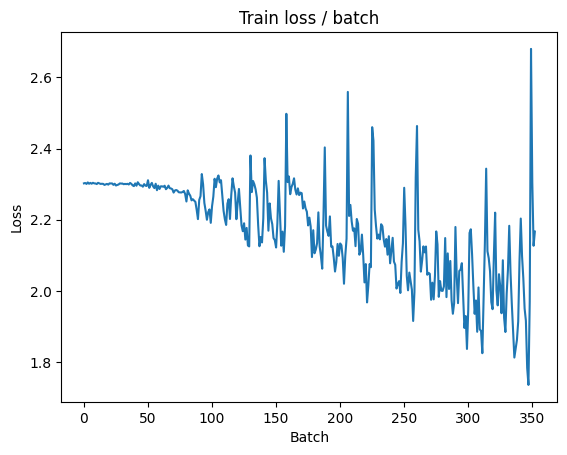

[TRAIN Batch 200/352]	Time 0.020s (0.032s)	Loss 1.5027 (1.8290)	Prec@1  43.0 ( 33.8)	Prec@5  92.2 ( 84.7)


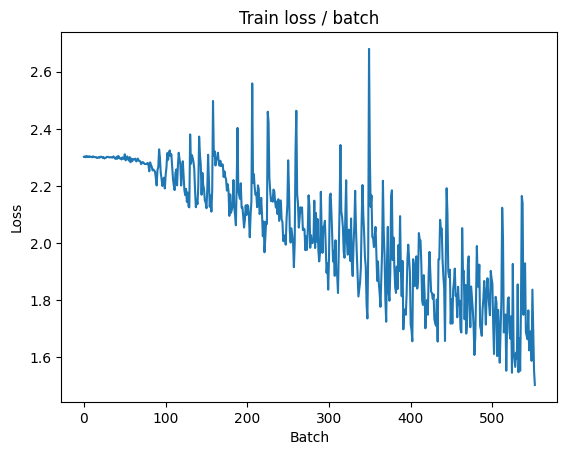


===============> Total time 9s	Avg loss 1.7366	Avg Prec@1 37.17 %	Avg Prec@5 86.85 %

[EVAL Batch 000/040]	Time 0.130s (0.130s)	Loss 1.6023 (1.6023)	Prec@1  36.7 ( 36.7)	Prec@5  89.1 ( 89.1)

===============> Total time 0s	Avg loss 1.6122	Avg Prec@1 42.60 %	Avg Prec@5 87.99 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 1.5269 (1.5269)	Prec@1  45.3 ( 45.3)	Prec@5  90.6 ( 90.6)

===============> Total time 1s	Avg loss 1.5735	Avg Prec@1 44.19 %	Avg Prec@5 88.80 %



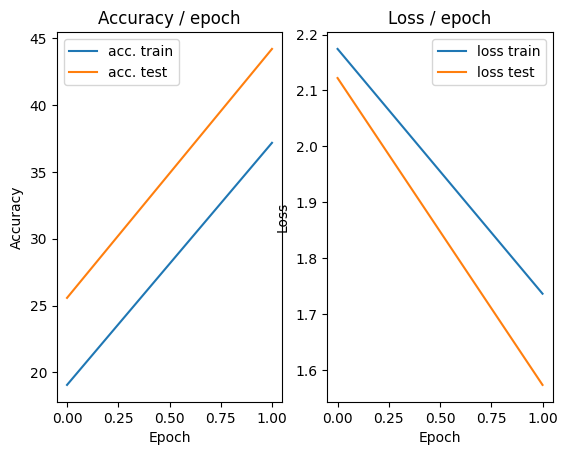

=== EPOCH 3 =====

[TRAIN Batch 000/352]	Time 0.443s (0.443s)	Loss 1.4235 (1.4235)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)


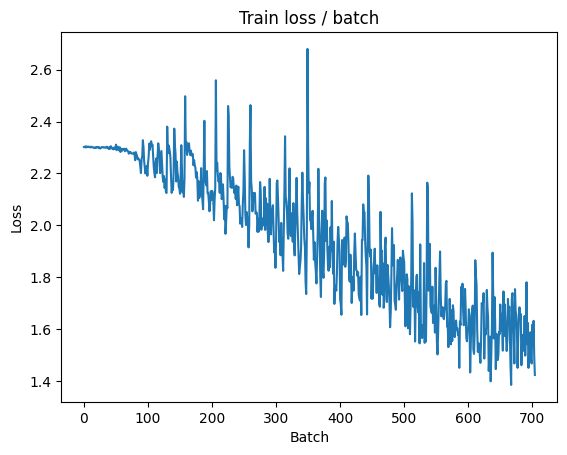

[TRAIN Batch 200/352]	Time 0.047s (0.032s)	Loss 1.3759 (1.5169)	Prec@1  54.7 ( 45.8)	Prec@5  90.6 ( 90.9)


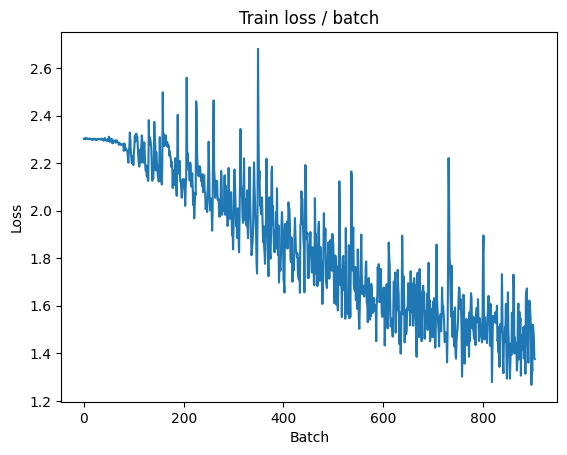


===============> Total time 9s	Avg loss 1.4749	Avg Prec@1 47.24 %	Avg Prec@5 91.79 %

[EVAL Batch 000/040]	Time 0.129s (0.129s)	Loss 1.3311 (1.3311)	Prec@1  50.8 ( 50.8)	Prec@5  93.0 ( 93.0)

===============> Total time 0s	Avg loss 1.4040	Avg Prec@1 49.61 %	Avg Prec@5 92.87 %

[EVAL Batch 000/079]	Time 0.114s (0.114s)	Loss 1.3438 (1.3438)	Prec@1  56.2 ( 56.2)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.4108	Avg Prec@1 49.14 %	Avg Prec@5 92.62 %



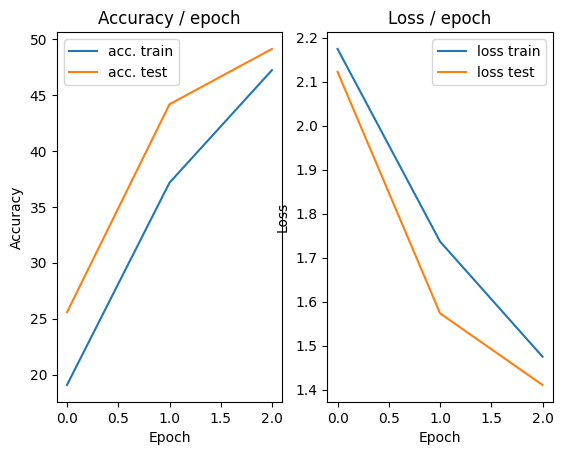

=== EPOCH 4 =====

[TRAIN Batch 000/352]	Time 0.219s (0.219s)	Loss 1.4621 (1.4621)	Prec@1  46.1 ( 46.1)	Prec@5  93.0 ( 93.0)


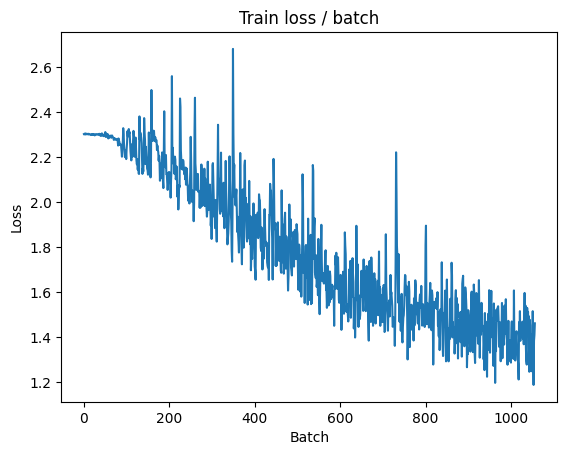

[TRAIN Batch 200/352]	Time 0.055s (0.025s)	Loss 1.2840 (1.3407)	Prec@1  50.8 ( 52.0)	Prec@5  94.5 ( 93.8)


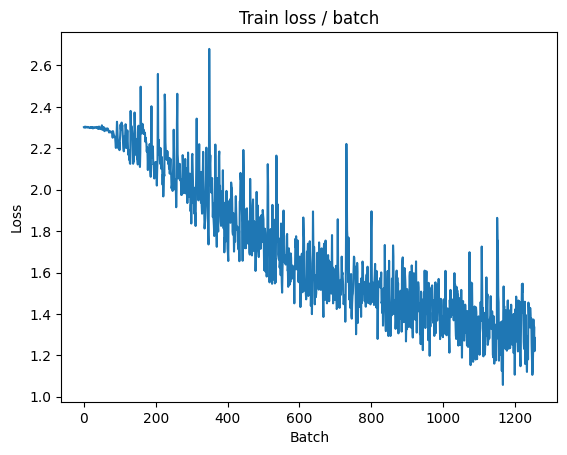


===============> Total time 9s	Avg loss 1.3159	Avg Prec@1 53.05 %	Avg Prec@5 93.93 %

[EVAL Batch 000/040]	Time 0.154s (0.154s)	Loss 1.2202 (1.2202)	Prec@1  54.7 ( 54.7)	Prec@5  95.3 ( 95.3)

===============> Total time 0s	Avg loss 1.2421	Avg Prec@1 55.49 %	Avg Prec@5 94.82 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 1.1298 (1.1298)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.2551	Avg Prec@1 55.17 %	Avg Prec@5 94.45 %



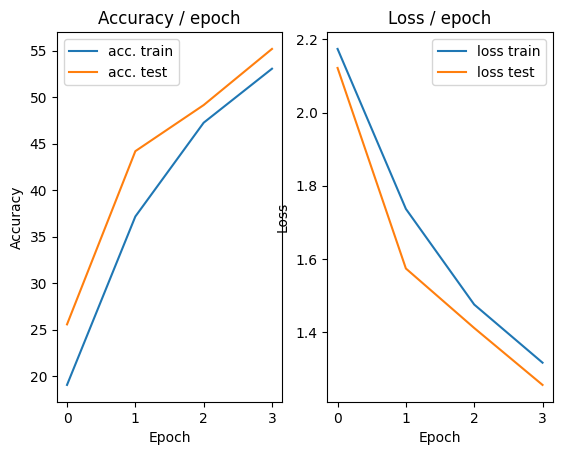

=== EPOCH 5 =====

[TRAIN Batch 000/352]	Time 0.456s (0.456s)	Loss 1.3239 (1.3239)	Prec@1  46.9 ( 46.9)	Prec@5  92.2 ( 92.2)


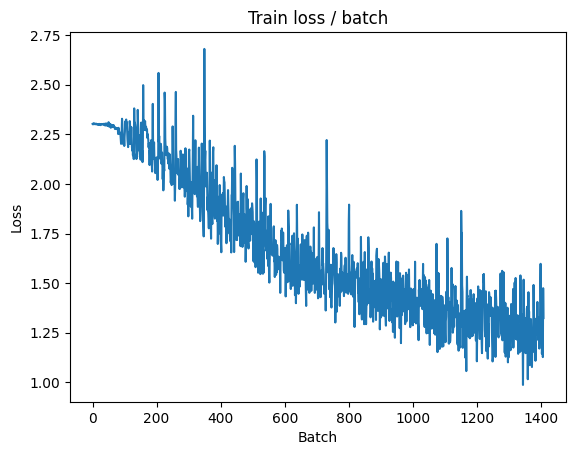

[TRAIN Batch 200/352]	Time 0.016s (0.024s)	Loss 1.2483 (1.2031)	Prec@1  56.2 ( 57.1)	Prec@5  94.5 ( 95.3)


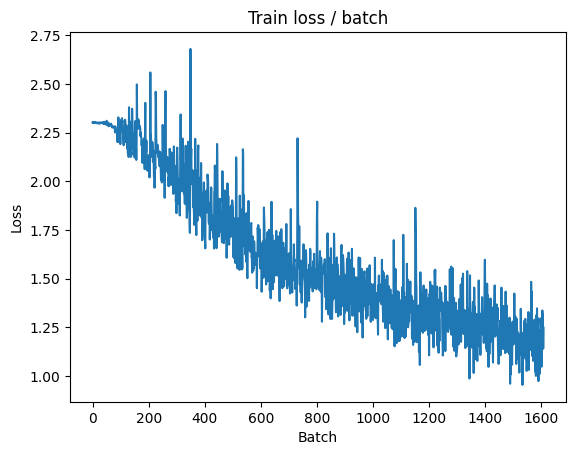


===============> Total time 9s	Avg loss 1.1816	Avg Prec@1 58.10 %	Avg Prec@5 95.43 %

[EVAL Batch 000/040]	Time 0.213s (0.213s)	Loss 1.1958 (1.1958)	Prec@1  57.8 ( 57.8)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.1980	Avg Prec@1 57.15 %	Avg Prec@5 95.39 %

[EVAL Batch 000/079]	Time 0.108s (0.108s)	Loss 1.0779 (1.0779)	Prec@1  64.8 ( 64.8)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.2129	Avg Prec@1 56.75 %	Avg Prec@5 94.94 %



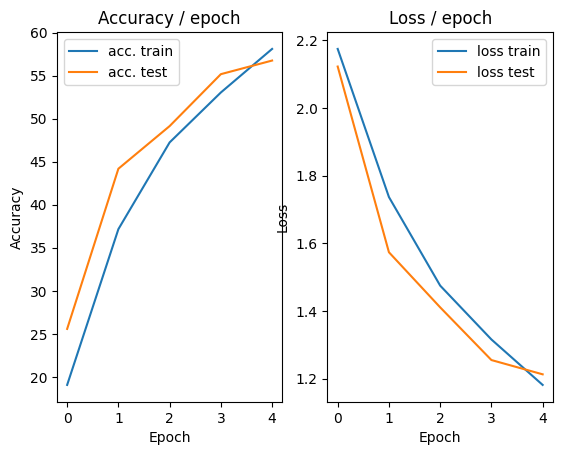

=== EPOCH 6 =====

[TRAIN Batch 000/352]	Time 0.245s (0.245s)	Loss 1.1529 (1.1529)	Prec@1  56.2 ( 56.2)	Prec@5  95.3 ( 95.3)


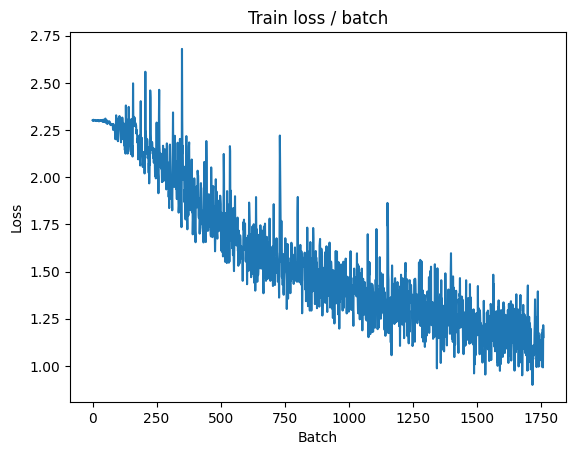

[TRAIN Batch 200/352]	Time 0.025s (0.024s)	Loss 1.0309 (1.0840)	Prec@1  64.1 ( 61.8)	Prec@5  96.9 ( 96.2)


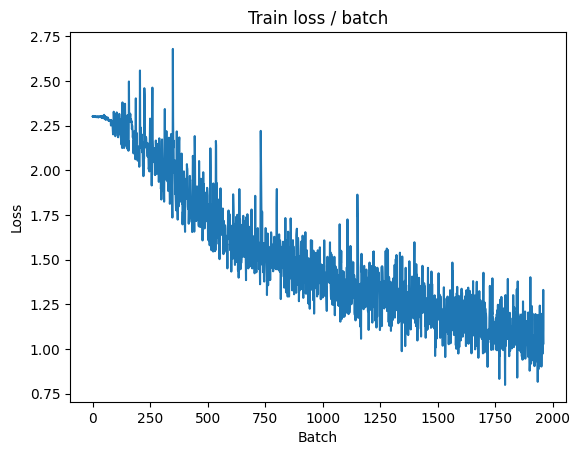


===============> Total time 8s	Avg loss 1.0639	Avg Prec@1 62.67 %	Avg Prec@5 96.40 %

[EVAL Batch 000/040]	Time 0.228s (0.228s)	Loss 1.1097 (1.1097)	Prec@1  60.9 ( 60.9)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1433	Avg Prec@1 59.12 %	Avg Prec@5 96.15 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 1.0966 (1.0966)	Prec@1  57.8 ( 57.8)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.1701	Avg Prec@1 58.00 %	Avg Prec@5 95.49 %



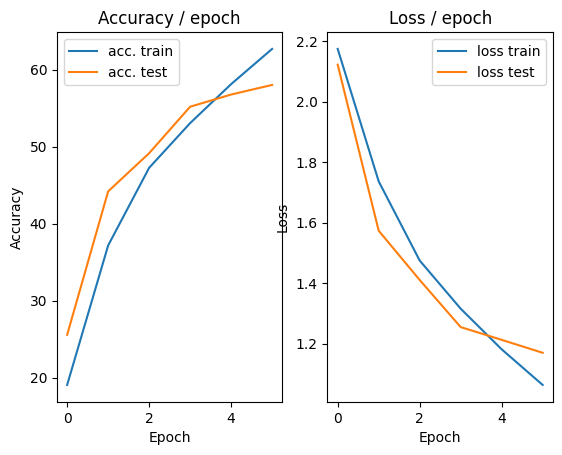

=== EPOCH 7 =====

[TRAIN Batch 000/352]	Time 0.243s (0.243s)	Loss 1.0817 (1.0817)	Prec@1  53.1 ( 53.1)	Prec@5  96.9 ( 96.9)


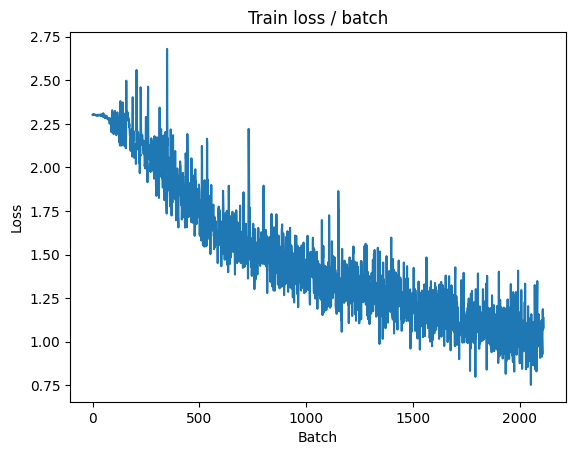

[TRAIN Batch 200/352]	Time 0.036s (0.023s)	Loss 1.2136 (0.9578)	Prec@1  51.6 ( 66.1)	Prec@5  94.5 ( 97.1)


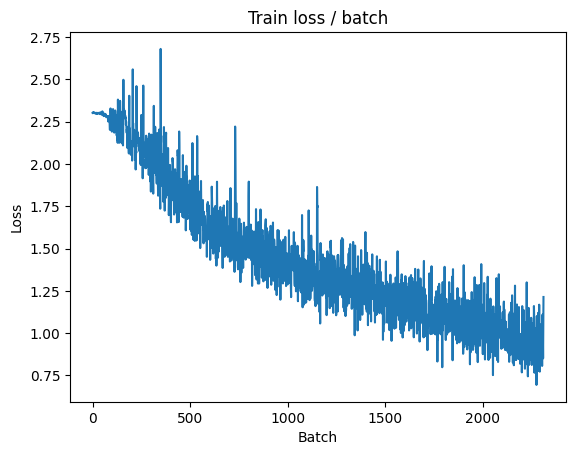


===============> Total time 8s	Avg loss 0.9519	Avg Prec@1 66.50 %	Avg Prec@5 97.16 %

[EVAL Batch 000/040]	Time 0.151s (0.151s)	Loss 1.1011 (1.1011)	Prec@1  63.3 ( 63.3)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0567	Avg Prec@1 63.16 %	Avg Prec@5 96.68 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 0.8932 (0.8932)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0926	Avg Prec@1 61.82 %	Avg Prec@5 96.28 %



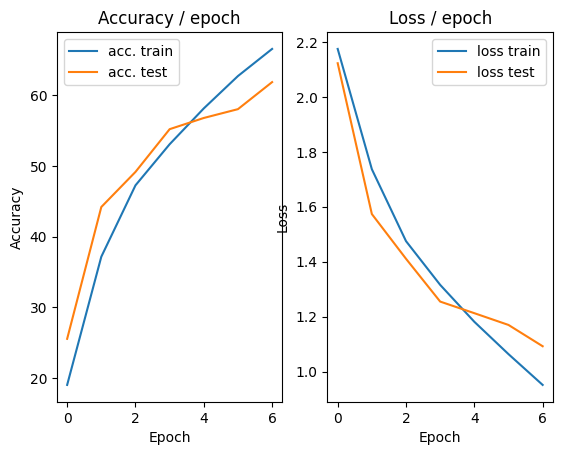

=== EPOCH 8 =====

[TRAIN Batch 000/352]	Time 0.556s (0.556s)	Loss 0.9436 (0.9436)	Prec@1  62.5 ( 62.5)	Prec@5  98.4 ( 98.4)


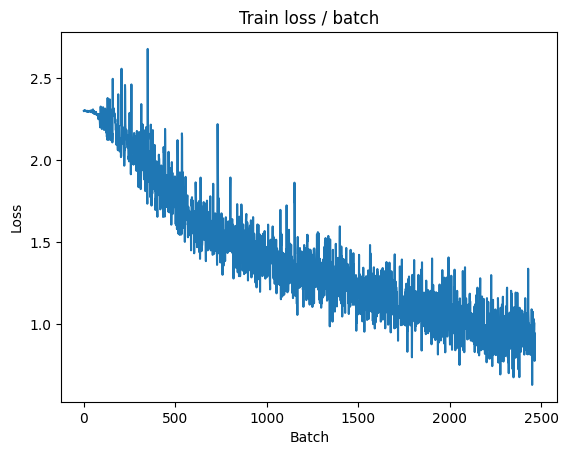

[TRAIN Batch 200/352]	Time 0.035s (0.025s)	Loss 0.7553 (0.8577)	Prec@1  71.9 ( 70.1)	Prec@5  96.9 ( 97.9)


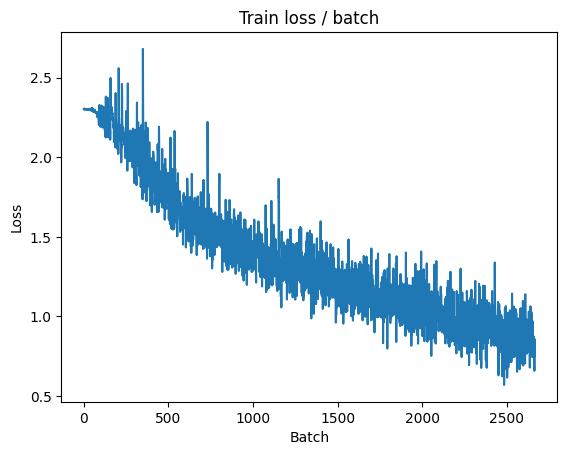


===============> Total time 8s	Avg loss 0.8545	Avg Prec@1 70.10 %	Avg Prec@5 97.95 %

[EVAL Batch 000/040]	Time 0.146s (0.146s)	Loss 0.9489 (0.9489)	Prec@1  66.4 ( 66.4)	Prec@5  97.7 ( 97.7)

===============> Total time 0s	Avg loss 0.9866	Avg Prec@1 65.27 %	Avg Prec@5 97.11 %

[EVAL Batch 000/079]	Time 0.118s (0.118s)	Loss 0.9317 (0.9317)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0245	Avg Prec@1 64.20 %	Avg Prec@5 96.59 %



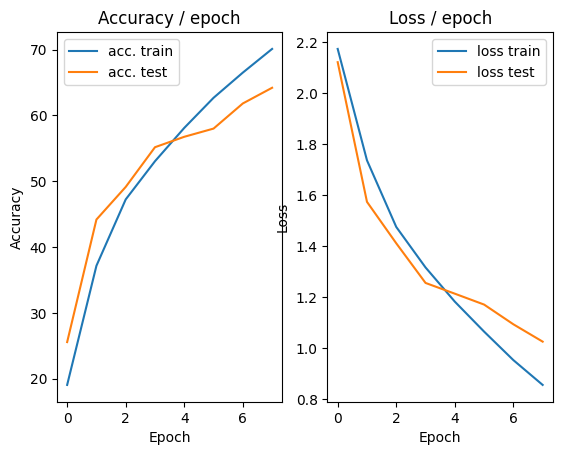

=== EPOCH 9 =====

[TRAIN Batch 000/352]	Time 0.339s (0.339s)	Loss 0.7424 (0.7424)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)


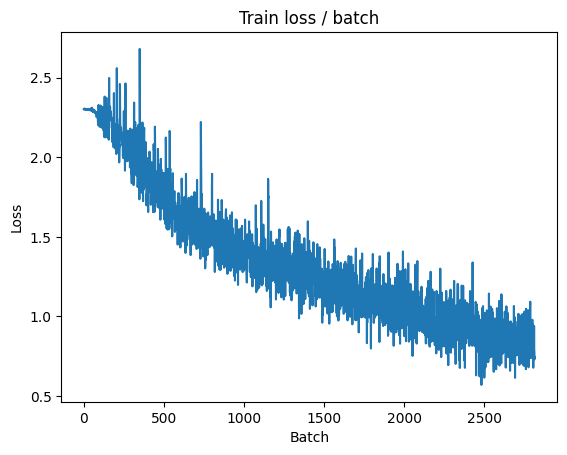

[TRAIN Batch 200/352]	Time 0.013s (0.028s)	Loss 0.5824 (0.7475)	Prec@1  78.1 ( 73.9)	Prec@5 100.0 ( 98.5)


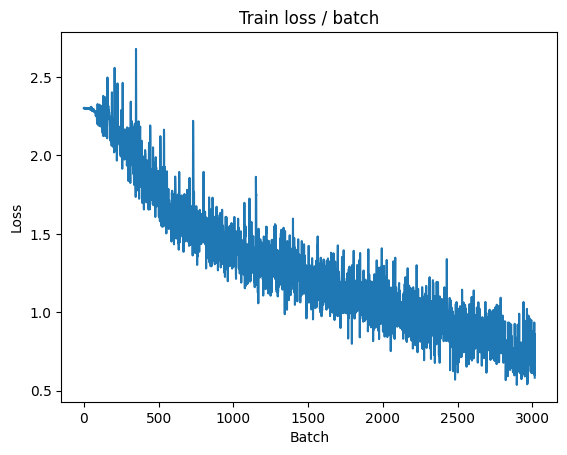


===============> Total time 9s	Avg loss 0.7481	Avg Prec@1 73.88 %	Avg Prec@5 98.46 %

[EVAL Batch 000/040]	Time 0.143s (0.143s)	Loss 0.8791 (0.8791)	Prec@1  73.4 ( 73.4)	Prec@5  95.3 ( 95.3)

===============> Total time 0s	Avg loss 0.9707	Avg Prec@1 65.74 %	Avg Prec@5 96.82 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 0.9557 (0.9557)	Prec@1  68.0 ( 68.0)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 0.9953	Avg Prec@1 65.81 %	Avg Prec@5 97.05 %



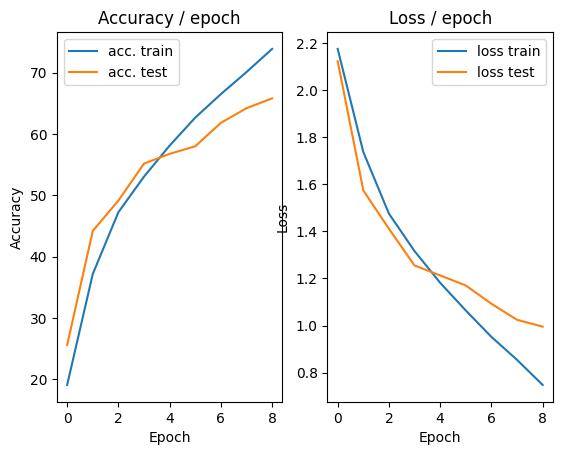

=== EPOCH 10 =====

[TRAIN Batch 000/352]	Time 0.451s (0.451s)	Loss 0.7067 (0.7067)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)


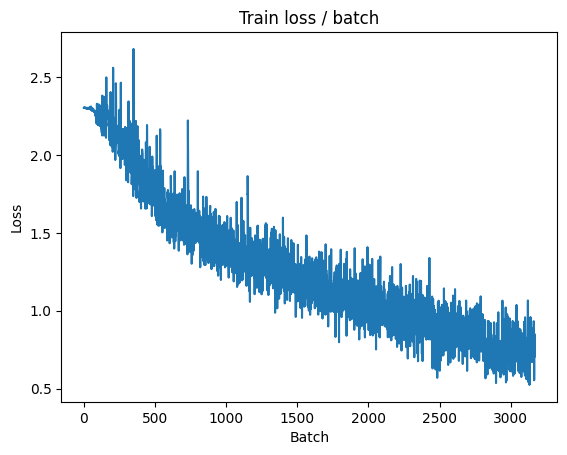

[TRAIN Batch 200/352]	Time 0.013s (0.032s)	Loss 0.6347 (0.6468)	Prec@1  73.4 ( 77.3)	Prec@5  99.2 ( 99.0)


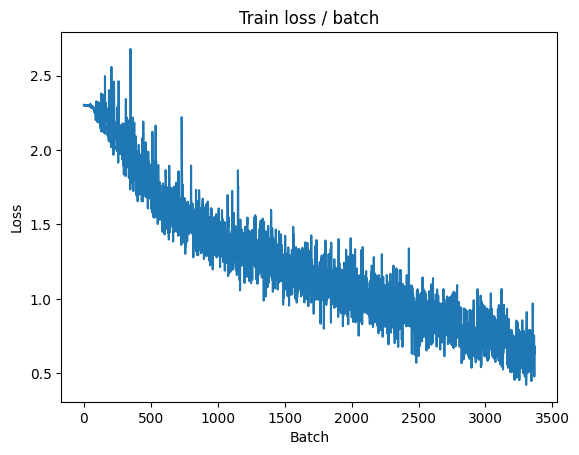


===============> Total time 9s	Avg loss 0.6543	Avg Prec@1 77.05 %	Avg Prec@5 98.93 %

[EVAL Batch 000/040]	Time 0.129s (0.129s)	Loss 0.7470 (0.7470)	Prec@1  69.5 ( 69.5)	Prec@5  98.4 ( 98.4)

===============> Total time 0s	Avg loss 0.9335	Avg Prec@1 67.99 %	Avg Prec@5 97.01 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 0.9527 (0.9527)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9811	Avg Prec@1 67.00 %	Avg Prec@5 96.89 %



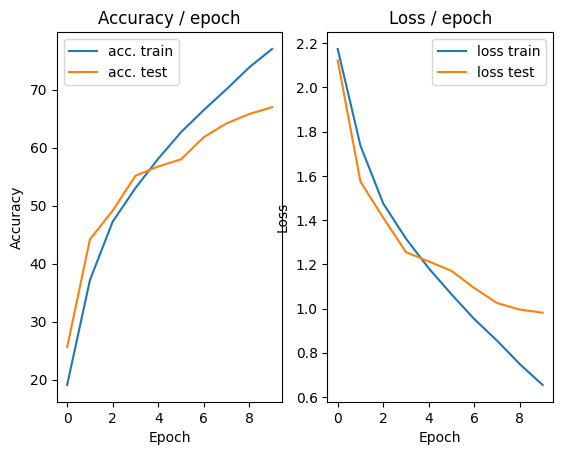

=== EPOCH 11 =====

[TRAIN Batch 000/352]	Time 0.252s (0.252s)	Loss 0.4672 (0.4672)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


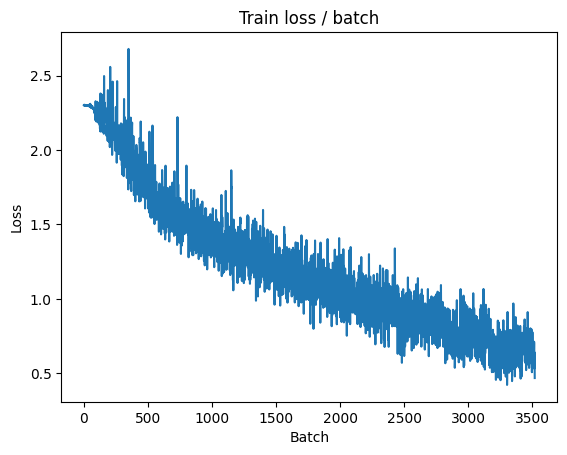

[TRAIN Batch 200/352]	Time 0.017s (0.030s)	Loss 0.5604 (0.5455)	Prec@1  80.5 ( 80.7)	Prec@5  99.2 ( 99.3)


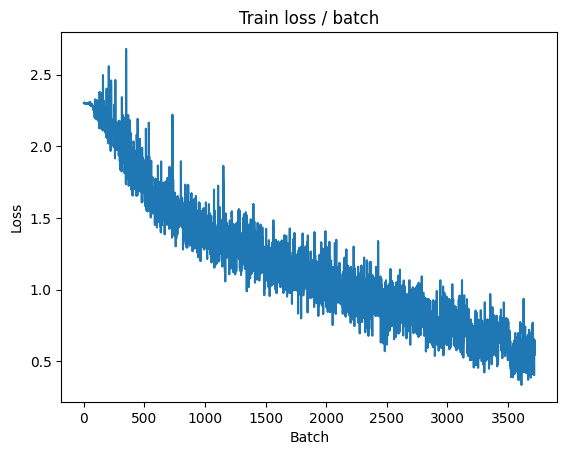


===============> Total time 9s	Avg loss 0.5633	Avg Prec@1 80.11 %	Avg Prec@5 99.21 %

[EVAL Batch 000/040]	Time 0.140s (0.140s)	Loss 1.1036 (1.1036)	Prec@1  63.3 ( 63.3)	Prec@5  94.5 ( 94.5)

===============> Total time 0s	Avg loss 0.9533	Avg Prec@1 68.12 %	Avg Prec@5 97.13 %

[EVAL Batch 000/079]	Time 0.128s (0.128s)	Loss 0.9400 (0.9400)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9789	Avg Prec@1 67.60 %	Avg Prec@5 96.96 %



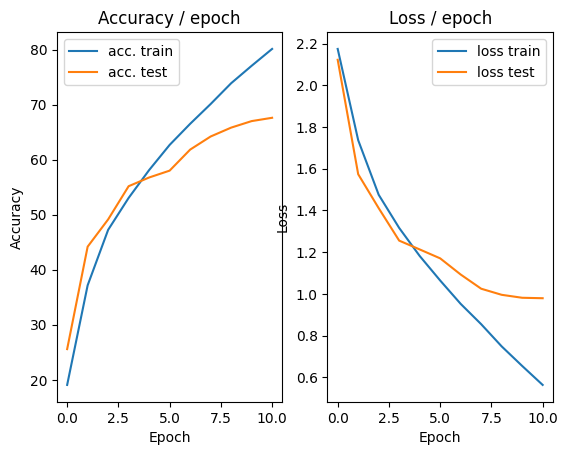

=== EPOCH 12 =====

[TRAIN Batch 000/352]	Time 0.456s (0.456s)	Loss 0.4876 (0.4876)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


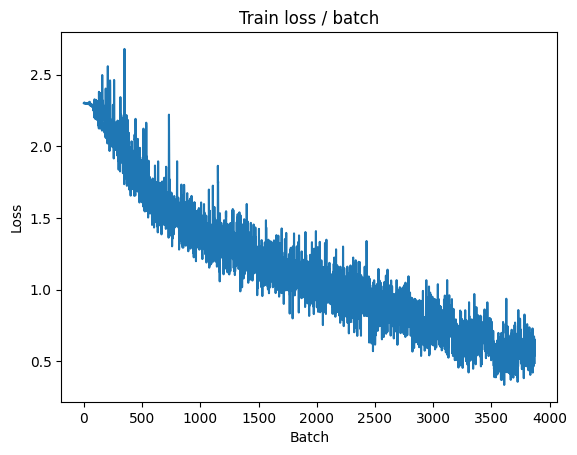

[TRAIN Batch 200/352]	Time 0.023s (0.026s)	Loss 0.4947 (0.4433)	Prec@1  82.8 ( 84.4)	Prec@5  99.2 ( 99.6)


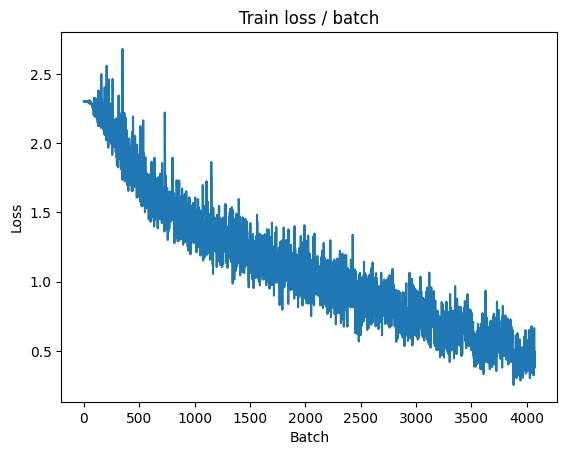


===============> Total time 9s	Avg loss 0.4573	Avg Prec@1 83.91 %	Avg Prec@5 99.56 %

[EVAL Batch 000/040]	Time 0.149s (0.149s)	Loss 1.1016 (1.1016)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)

===============> Total time 0s	Avg loss 1.1213	Avg Prec@1 65.41 %	Avg Prec@5 97.29 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.2018 (1.2018)	Prec@1  66.4 ( 66.4)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.1316	Avg Prec@1 64.65 %	Avg Prec@5 96.71 %



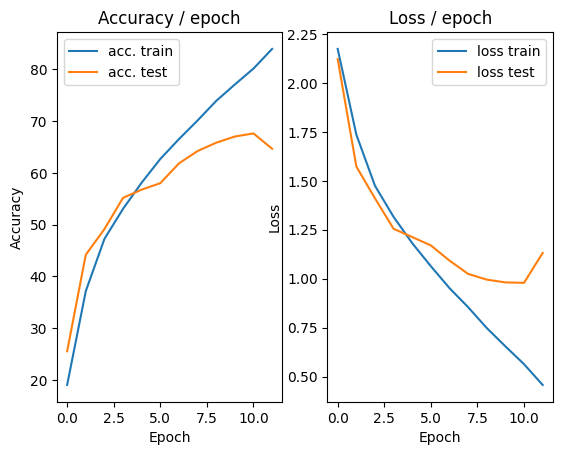

=== EPOCH 13 =====

[TRAIN Batch 000/352]	Time 0.256s (0.256s)	Loss 0.5108 (0.5108)	Prec@1  79.7 ( 79.7)	Prec@5 100.0 (100.0)


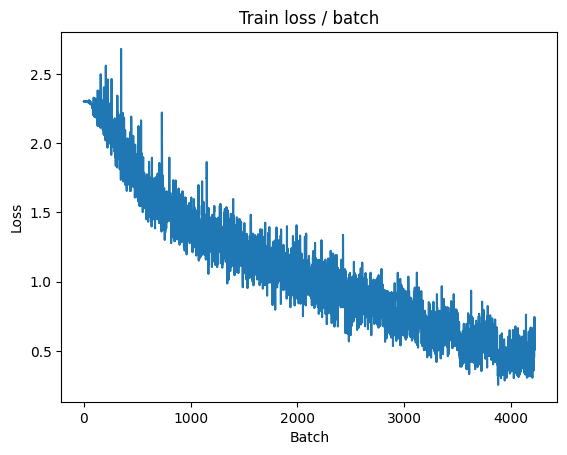

[TRAIN Batch 200/352]	Time 0.016s (0.024s)	Loss 0.3202 (0.3509)	Prec@1  87.5 ( 88.1)	Prec@5 100.0 ( 99.8)


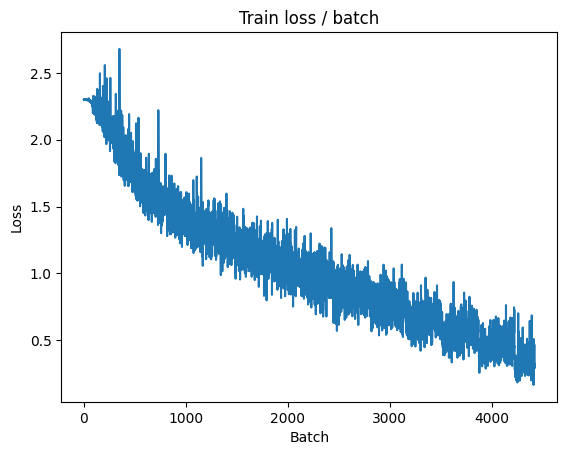


===============> Total time 9s	Avg loss 0.3671	Avg Prec@1 87.39 %	Avg Prec@5 99.76 %

[EVAL Batch 000/040]	Time 0.185s (0.185s)	Loss 1.0610 (1.0610)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 0s	Avg loss 1.1066	Avg Prec@1 68.12 %	Avg Prec@5 96.62 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.2535 (1.2535)	Prec@1  69.5 ( 69.5)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.1757	Avg Prec@1 65.78 %	Avg Prec@5 96.00 %



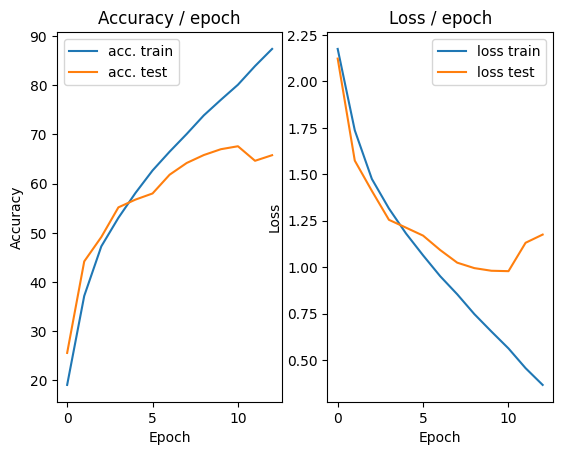

=== EPOCH 14 =====

[TRAIN Batch 000/352]	Time 0.260s (0.260s)	Loss 0.3960 (0.3960)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


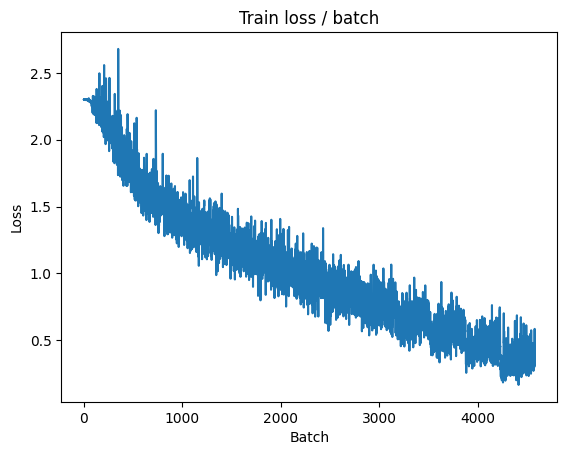

[TRAIN Batch 200/352]	Time 0.031s (0.023s)	Loss 0.2204 (0.2691)	Prec@1  91.4 ( 90.7)	Prec@5 100.0 ( 99.9)


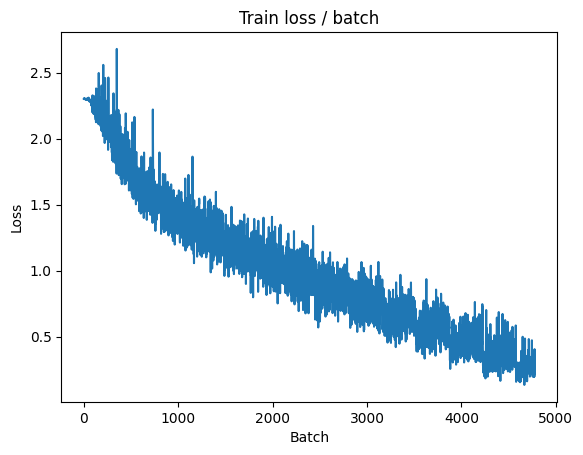


===============> Total time 8s	Avg loss 0.2898	Avg Prec@1 89.77 %	Avg Prec@5 99.88 %

[EVAL Batch 000/040]	Time 0.231s (0.231s)	Loss 1.4030 (1.4030)	Prec@1  65.6 ( 65.6)	Prec@5  92.2 ( 92.2)

===============> Total time 1s	Avg loss 1.1228	Avg Prec@1 68.05 %	Avg Prec@5 97.11 %

[EVAL Batch 000/079]	Time 0.202s (0.202s)	Loss 1.1840 (1.1840)	Prec@1  71.1 ( 71.1)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.1666	Avg Prec@1 67.59 %	Avg Prec@5 96.75 %



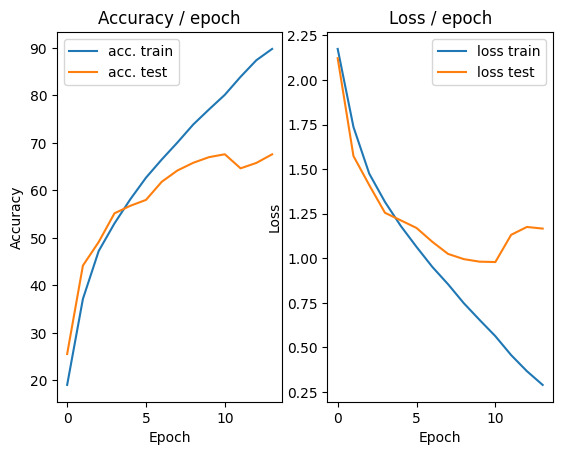

=== EPOCH 15 =====

[TRAIN Batch 000/352]	Time 0.459s (0.459s)	Loss 0.2407 (0.2407)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


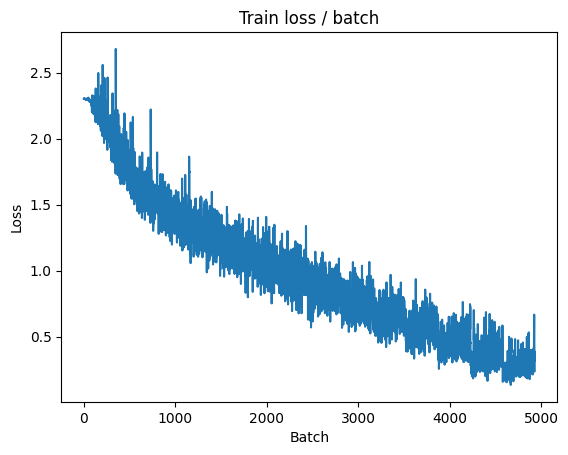

[TRAIN Batch 200/352]	Time 0.012s (0.024s)	Loss 0.2544 (0.1750)	Prec@1  92.2 ( 94.2)	Prec@5 100.0 (100.0)


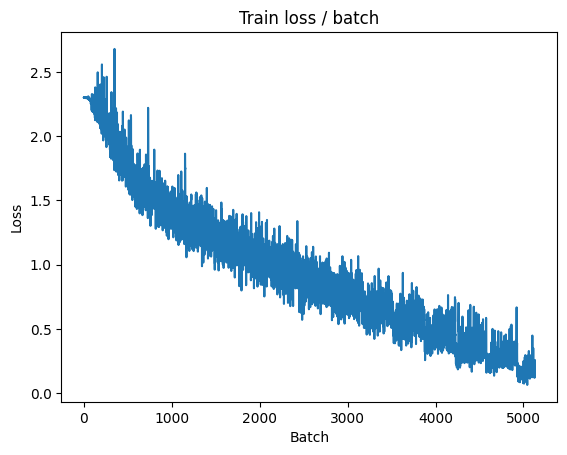


===============> Total time 8s	Avg loss 0.1980	Avg Prec@1 93.27 %	Avg Prec@5 99.97 %

[EVAL Batch 000/040]	Time 0.143s (0.143s)	Loss 1.2926 (1.2926)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)

===============> Total time 0s	Avg loss 1.3449	Avg Prec@1 66.78 %	Avg Prec@5 96.39 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 1.5088 (1.5088)	Prec@1  65.6 ( 65.6)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.4609	Avg Prec@1 64.76 %	Avg Prec@5 96.39 %



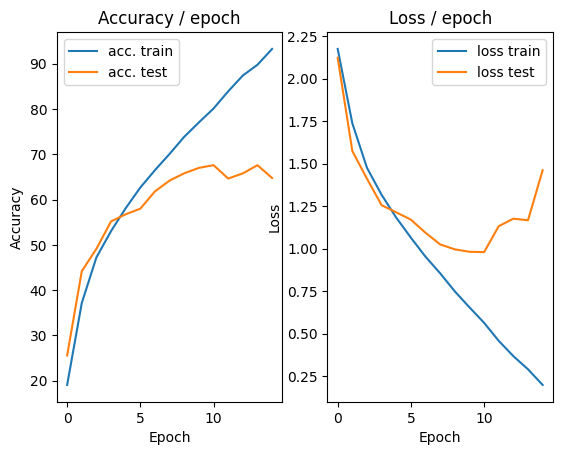

=== EPOCH 16 =====

[TRAIN Batch 000/352]	Time 0.356s (0.356s)	Loss 0.2878 (0.2878)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


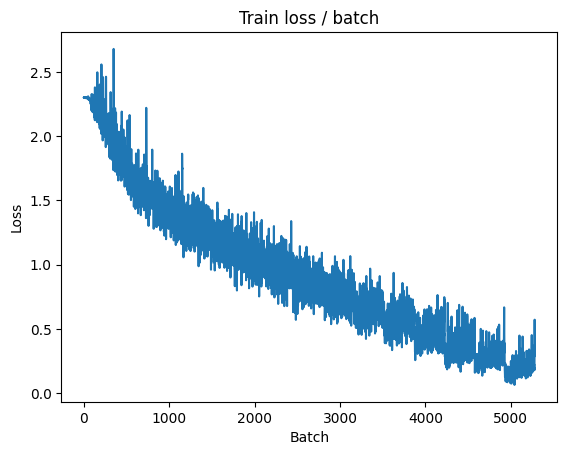

[TRAIN Batch 200/352]	Time 0.015s (0.024s)	Loss 0.2125 (0.1233)	Prec@1  92.2 ( 96.2)	Prec@5  99.2 (100.0)


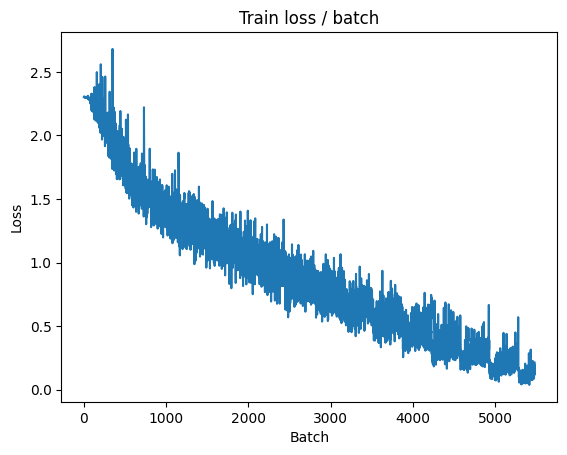


===============> Total time 8s	Avg loss 0.1417	Avg Prec@1 95.34 %	Avg Prec@5 99.98 %

[EVAL Batch 000/040]	Time 0.139s (0.139s)	Loss 1.6010 (1.6010)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)

===============> Total time 0s	Avg loss 1.4020	Avg Prec@1 68.85 %	Avg Prec@5 96.76 %

[EVAL Batch 000/079]	Time 0.128s (0.128s)	Loss 1.3780 (1.3780)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.4637	Avg Prec@1 67.82 %	Avg Prec@5 96.67 %



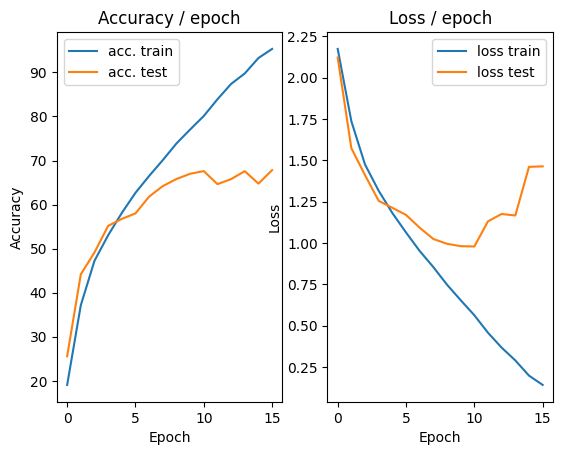

=== EPOCH 17 =====

[TRAIN Batch 000/352]	Time 0.704s (0.704s)	Loss 0.1380 (0.1380)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


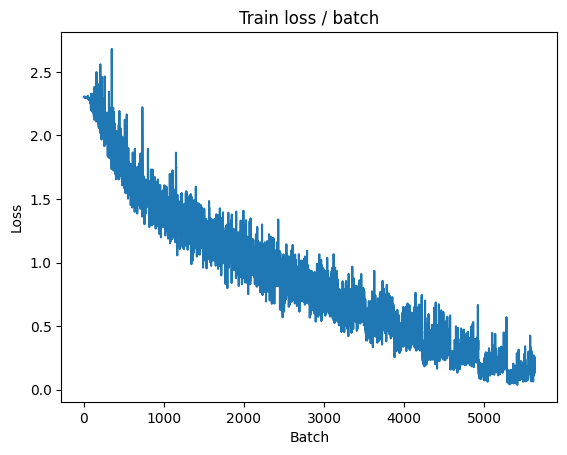

[TRAIN Batch 200/352]	Time 0.018s (0.038s)	Loss 0.1050 (0.0740)	Prec@1  95.3 ( 97.8)	Prec@5 100.0 (100.0)


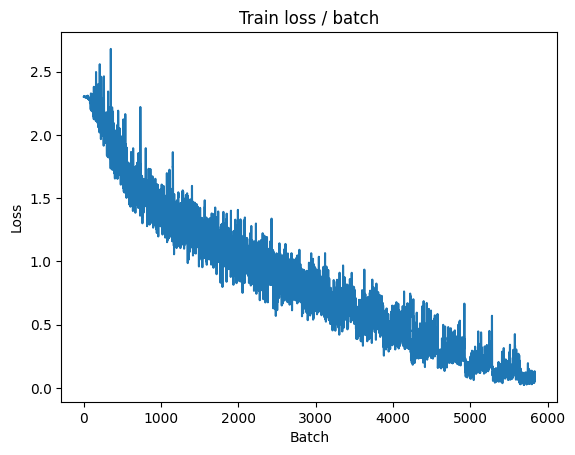


===============> Total time 11s	Avg loss 0.1025	Avg Prec@1 96.79 %	Avg Prec@5 99.98 %

[EVAL Batch 000/040]	Time 0.162s (0.162s)	Loss 1.4507 (1.4507)	Prec@1  68.8 ( 68.8)	Prec@5  96.9 ( 96.9)

===============> Total time 0s	Avg loss 1.4498	Avg Prec@1 68.83 %	Avg Prec@5 97.44 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 1.5611 (1.5611)	Prec@1  61.7 ( 61.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.5377	Avg Prec@1 67.33 %	Avg Prec@5 96.91 %



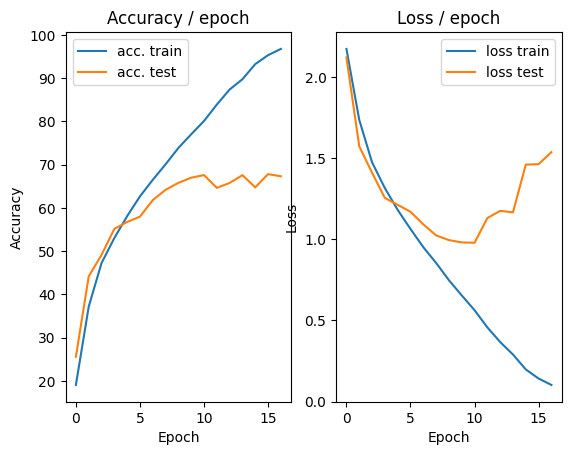

=== EPOCH 18 =====

[TRAIN Batch 000/352]	Time 0.247s (0.247s)	Loss 0.1043 (0.1043)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


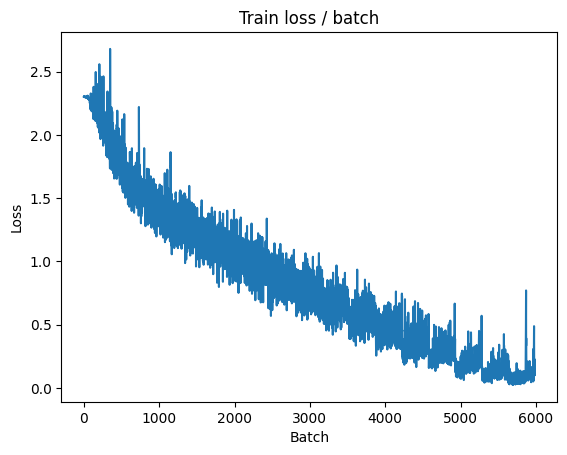

[TRAIN Batch 200/352]	Time 0.013s (0.031s)	Loss 0.2076 (0.0568)	Prec@1  93.8 ( 98.4)	Prec@5 100.0 (100.0)


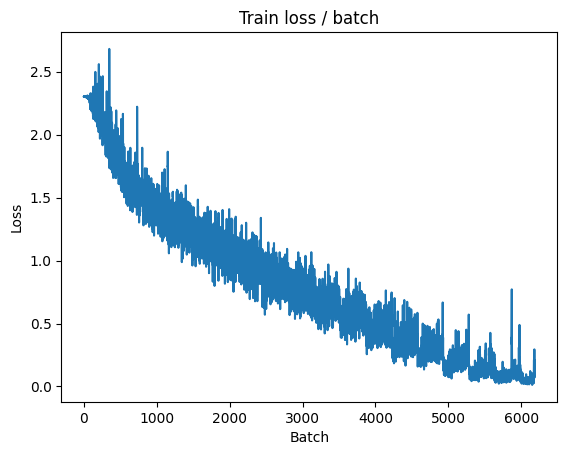


===============> Total time 9s	Avg loss 0.0681	Avg Prec@1 97.86 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.152s (0.152s)	Loss 1.5859 (1.5859)	Prec@1  68.0 ( 68.0)	Prec@5  98.4 ( 98.4)

===============> Total time 0s	Avg loss 1.5398	Avg Prec@1 70.08 %	Avg Prec@5 97.42 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.7043 (1.7043)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.6923	Avg Prec@1 67.11 %	Avg Prec@5 97.12 %



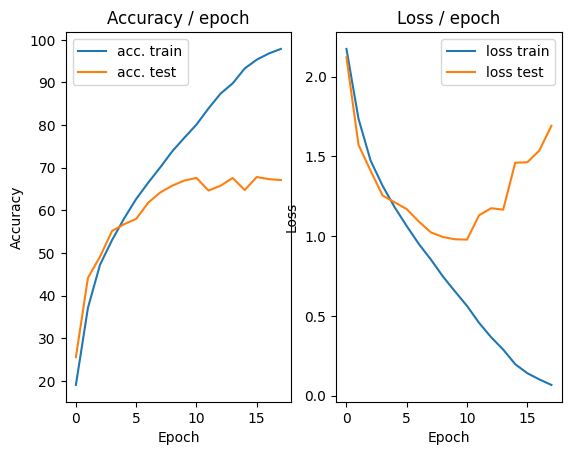

=== EPOCH 19 =====

[TRAIN Batch 000/352]	Time 0.450s (0.450s)	Loss 0.0978 (0.0978)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


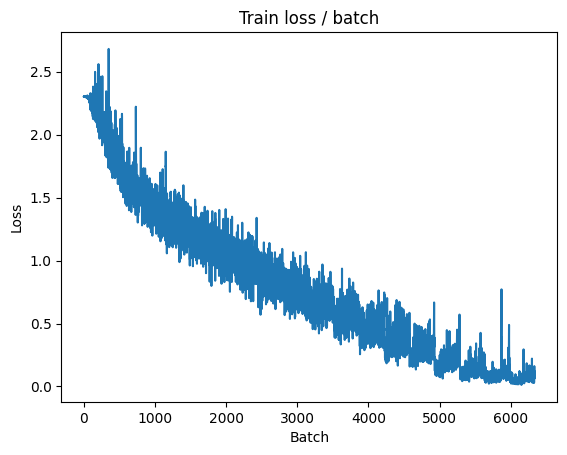

[TRAIN Batch 200/352]	Time 0.011s (0.029s)	Loss 0.0261 (0.0304)	Prec@1 100.0 ( 99.2)	Prec@5 100.0 (100.0)


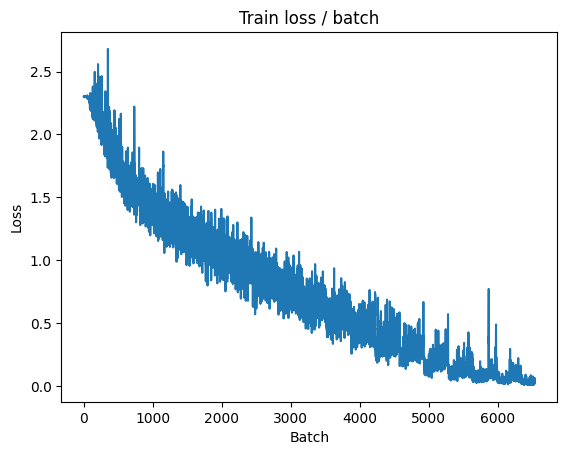


===============> Total time 9s	Avg loss 0.0465	Avg Prec@1 98.63 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.152s (0.152s)	Loss 1.4901 (1.4901)	Prec@1  73.4 ( 73.4)	Prec@5  96.1 ( 96.1)

===============> Total time 0s	Avg loss 1.7277	Avg Prec@1 68.83 %	Avg Prec@5 96.74 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 2.0599 (2.0599)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.7663	Avg Prec@1 67.85 %	Avg Prec@5 96.89 %



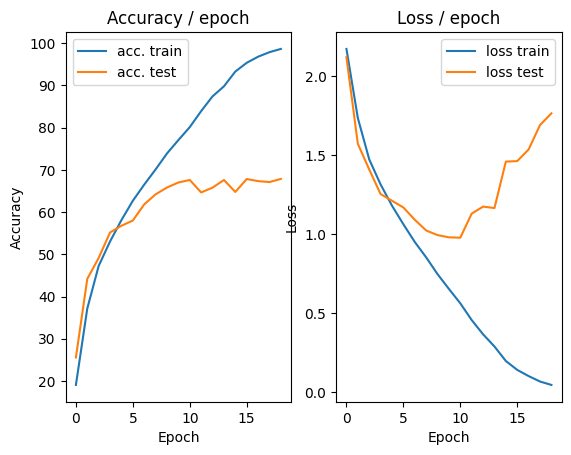

=== EPOCH 20 =====

[TRAIN Batch 000/352]	Time 0.255s (0.255s)	Loss 0.0629 (0.0629)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


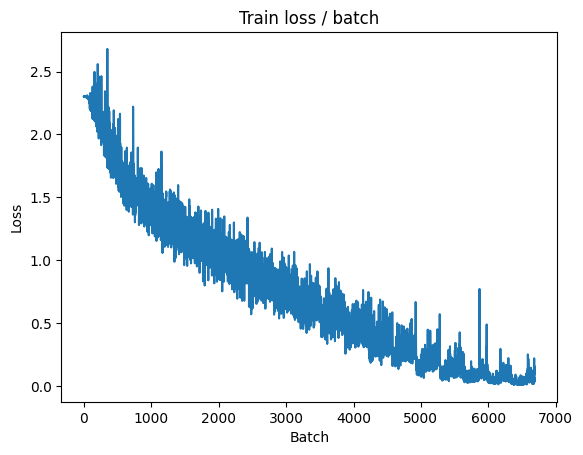

[TRAIN Batch 200/352]	Time 0.011s (0.024s)	Loss 0.0223 (0.0311)	Prec@1  99.2 ( 99.1)	Prec@5 100.0 (100.0)


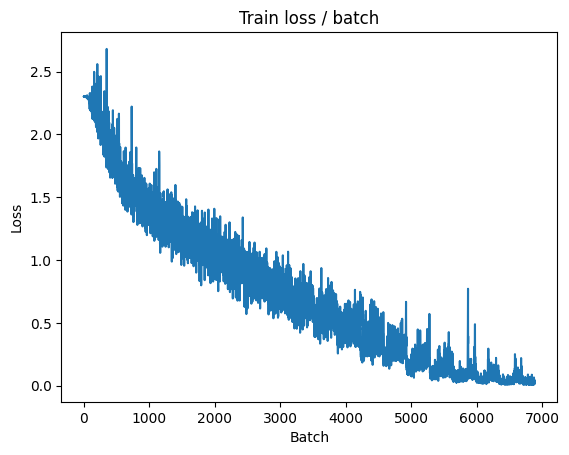


===============> Total time 9s	Avg loss 0.0435	Avg Prec@1 98.69 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.154s (0.154s)	Loss 2.0287 (2.0287)	Prec@1  63.3 ( 63.3)	Prec@5  95.3 ( 95.3)

===============> Total time 0s	Avg loss 2.4497	Avg Prec@1 62.15 %	Avg Prec@5 96.29 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 2.8128 (2.8128)	Prec@1  58.6 ( 58.6)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.5597	Avg Prec@1 60.77 %	Avg Prec@5 95.74 %



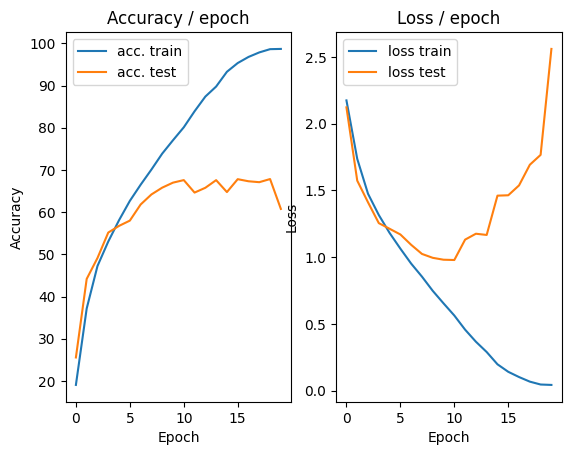

=== EPOCH 21 =====

[TRAIN Batch 000/352]	Time 0.255s (0.255s)	Loss 0.3513 (0.3513)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


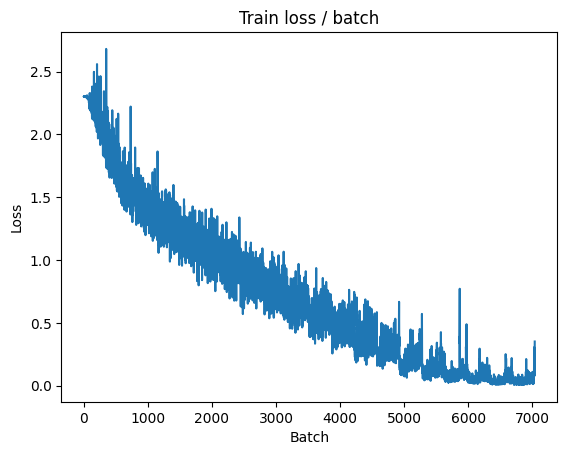

[TRAIN Batch 200/352]	Time 0.034s (0.024s)	Loss 0.0062 (0.0509)	Prec@1 100.0 ( 98.6)	Prec@5 100.0 (100.0)


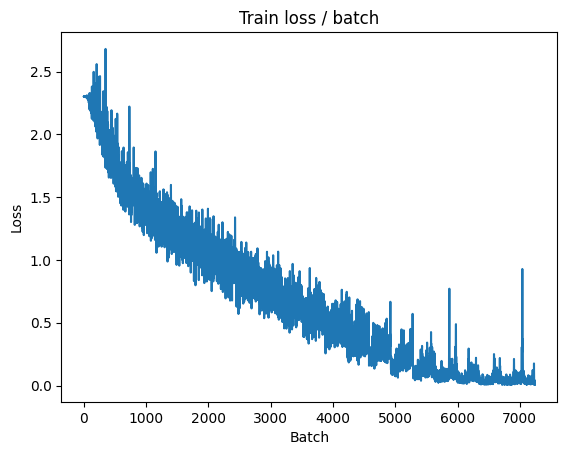


===============> Total time 9s	Avg loss 0.0630	Avg Prec@1 98.14 %	Avg Prec@5 99.99 %

[EVAL Batch 000/040]	Time 0.234s (0.234s)	Loss 1.2562 (1.2562)	Prec@1  71.1 ( 71.1)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 1.7605	Avg Prec@1 69.04 %	Avg Prec@5 96.97 %

[EVAL Batch 000/079]	Time 0.195s (0.195s)	Loss 1.9568 (1.9568)	Prec@1  71.9 ( 71.9)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.8423	Avg Prec@1 68.27 %	Avg Prec@5 96.86 %



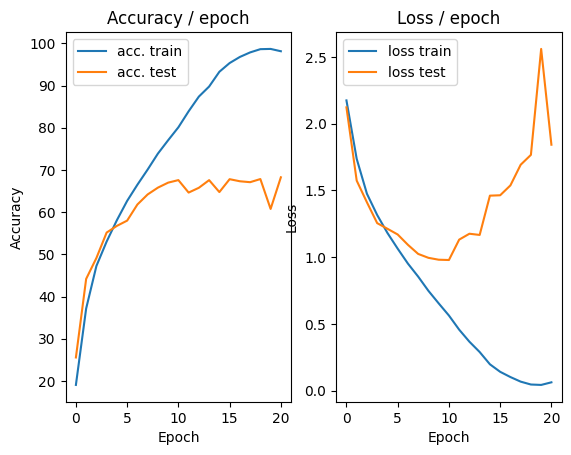

=== EPOCH 22 =====

[TRAIN Batch 000/352]	Time 0.496s (0.496s)	Loss 0.1034 (0.1034)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


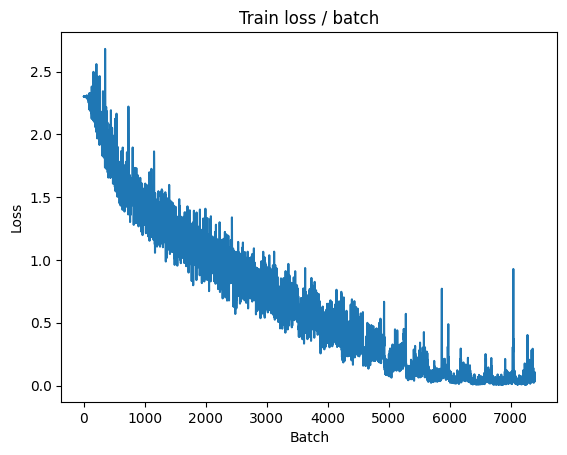

[TRAIN Batch 200/352]	Time 0.018s (0.024s)	Loss 0.0390 (0.0341)	Prec@1  99.2 ( 99.1)	Prec@5 100.0 (100.0)


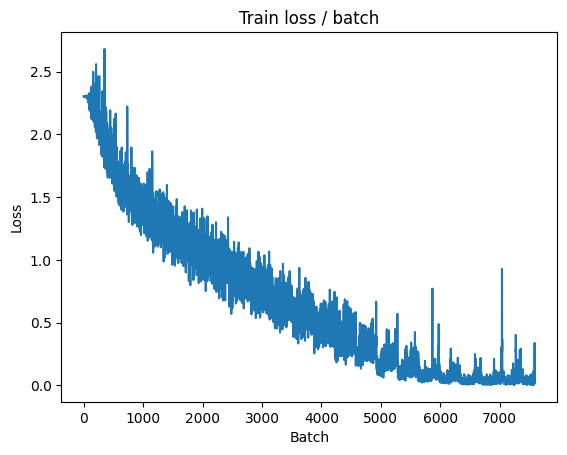


===============> Total time 8s	Avg loss 0.0326	Avg Prec@1 99.10 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.201s (0.201s)	Loss 2.1303 (2.1303)	Prec@1  65.6 ( 65.6)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.7981	Avg Prec@1 70.96 %	Avg Prec@5 97.15 %

[EVAL Batch 000/079]	Time 0.202s (0.202s)	Loss 2.2585 (2.2585)	Prec@1  65.6 ( 65.6)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.9055	Avg Prec@1 69.27 %	Avg Prec@5 96.71 %



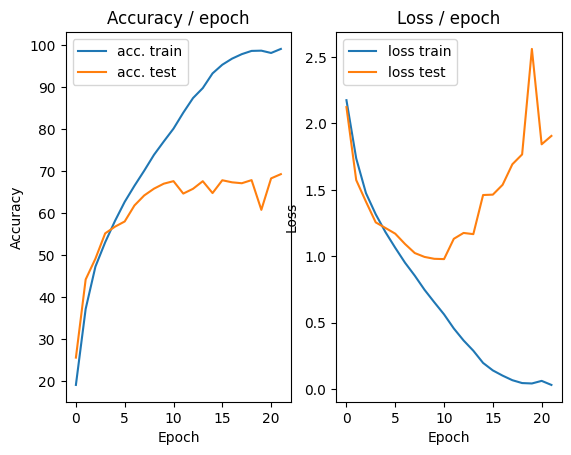

=== EPOCH 23 =====

[TRAIN Batch 000/352]	Time 0.269s (0.269s)	Loss 0.0249 (0.0249)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


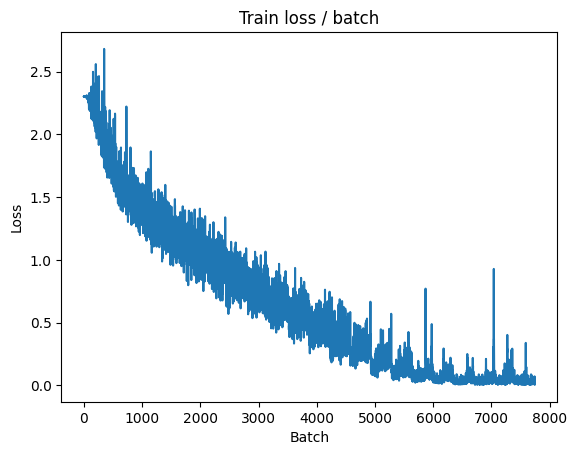

[TRAIN Batch 200/352]	Time 0.014s (0.023s)	Loss 0.0106 (0.0120)	Prec@1 100.0 ( 99.8)	Prec@5 100.0 (100.0)


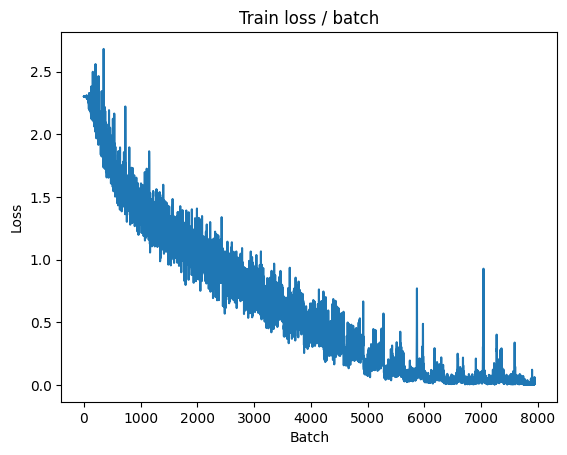


===============> Total time 8s	Avg loss 0.0143	Avg Prec@1 99.66 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.159s (0.159s)	Loss 1.5034 (1.5034)	Prec@1  73.4 ( 73.4)	Prec@5  98.4 ( 98.4)

===============> Total time 0s	Avg loss 1.8001	Avg Prec@1 71.86 %	Avg Prec@5 97.13 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 2.0920 (2.0920)	Prec@1  68.8 ( 68.8)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.9532	Avg Prec@1 69.83 %	Avg Prec@5 97.12 %



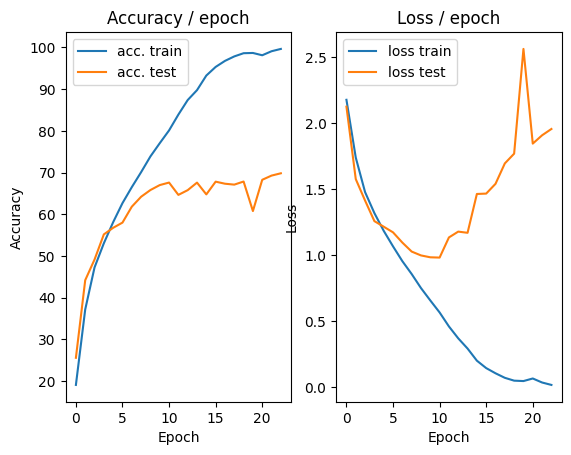

=== EPOCH 24 =====

[TRAIN Batch 000/352]	Time 0.688s (0.688s)	Loss 0.0039 (0.0039)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


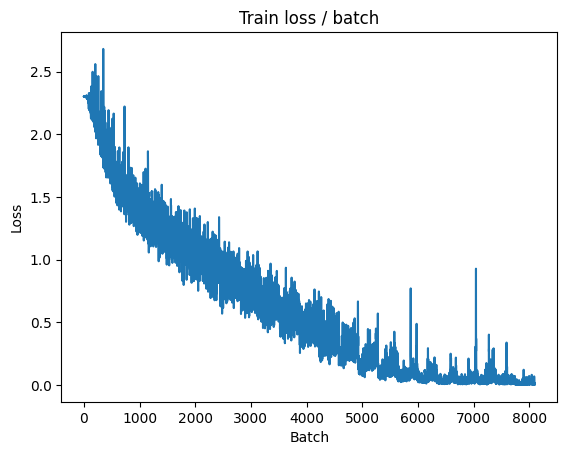

[TRAIN Batch 200/352]	Time 0.014s (0.028s)	Loss 0.0014 (0.0043)	Prec@1 100.0 ( 99.9)	Prec@5 100.0 (100.0)


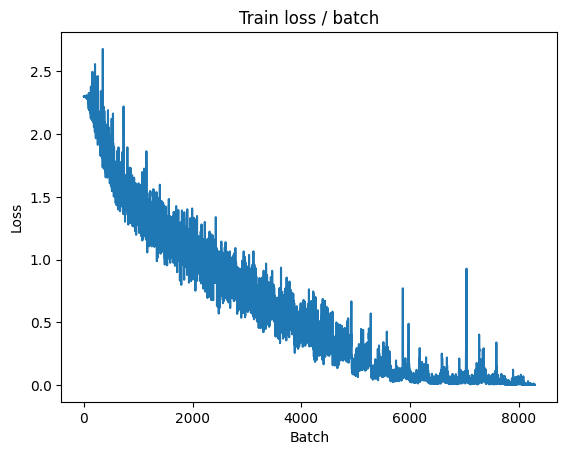


===============> Total time 8s	Avg loss 0.0036	Avg Prec@1 99.95 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.155s (0.155s)	Loss 2.6153 (2.6153)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)

===============> Total time 0s	Avg loss 1.9298	Avg Prec@1 72.05 %	Avg Prec@5 97.30 %

[EVAL Batch 000/079]	Time 0.140s (0.140s)	Loss 2.1786 (2.1786)	Prec@1  67.2 ( 67.2)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.0275	Avg Prec@1 70.39 %	Avg Prec@5 97.14 %



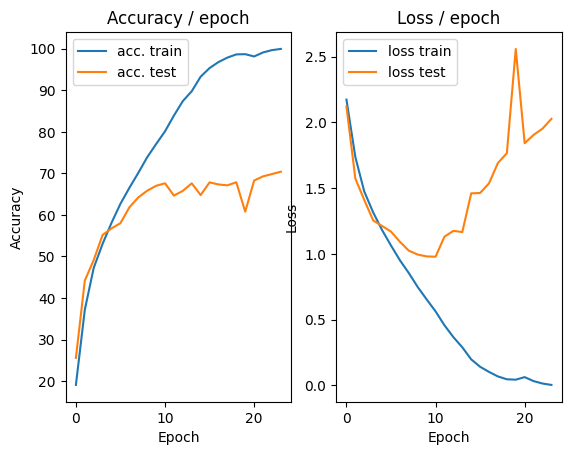

=== EPOCH 25 =====

[TRAIN Batch 000/352]	Time 0.261s (0.261s)	Loss 0.0015 (0.0015)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


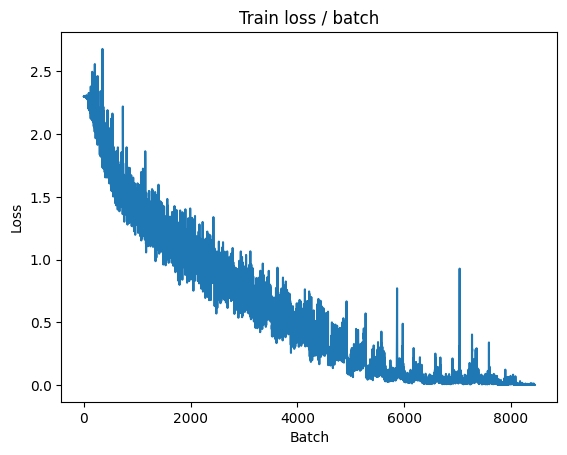

[TRAIN Batch 200/352]	Time 0.008s (0.031s)	Loss 0.0014 (0.0011)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


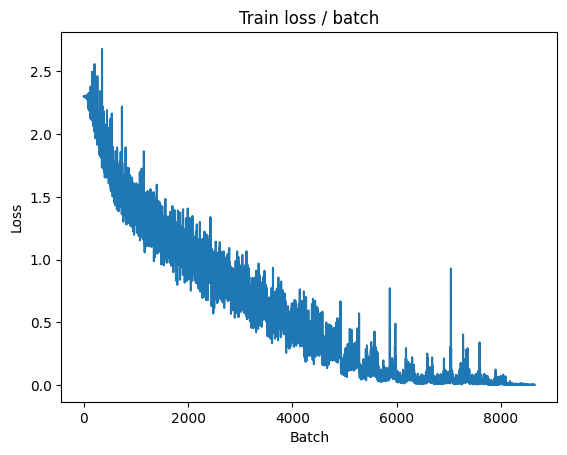


===============> Total time 9s	Avg loss 0.0011	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.150s (0.150s)	Loss 1.7602 (1.7602)	Prec@1  71.1 ( 71.1)	Prec@5  99.2 ( 99.2)

===============> Total time 0s	Avg loss 1.9777	Avg Prec@1 72.58 %	Avg Prec@5 97.23 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 2.2412 (2.2412)	Prec@1  69.5 ( 69.5)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.0830	Avg Prec@1 70.83 %	Avg Prec@5 97.26 %



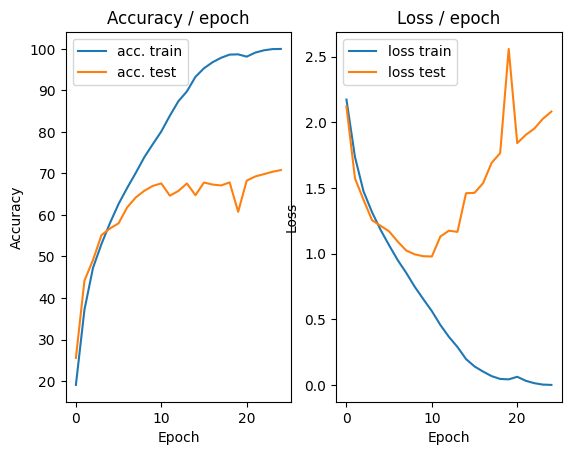

=== EPOCH 26 =====

[TRAIN Batch 000/352]	Time 0.261s (0.261s)	Loss 0.0004 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


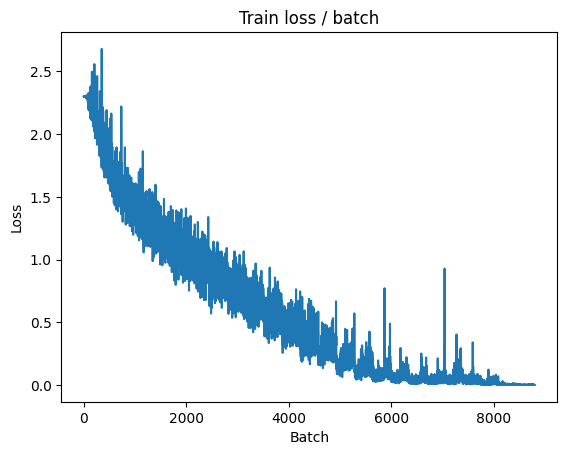

[TRAIN Batch 200/352]	Time 0.044s (0.032s)	Loss 0.0004 (0.0006)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


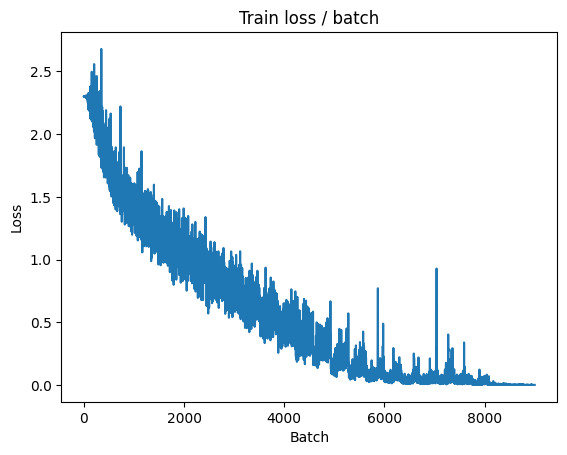


===============> Total time 9s	Avg loss 0.0006	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.150s (0.150s)	Loss 2.0468 (2.0468)	Prec@1  74.2 ( 74.2)	Prec@5  98.4 ( 98.4)

===============> Total time 0s	Avg loss 1.9890	Avg Prec@1 73.05 %	Avg Prec@5 97.56 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 2.2691 (2.2691)	Prec@1  70.3 ( 70.3)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.1341	Avg Prec@1 70.97 %	Avg Prec@5 97.33 %



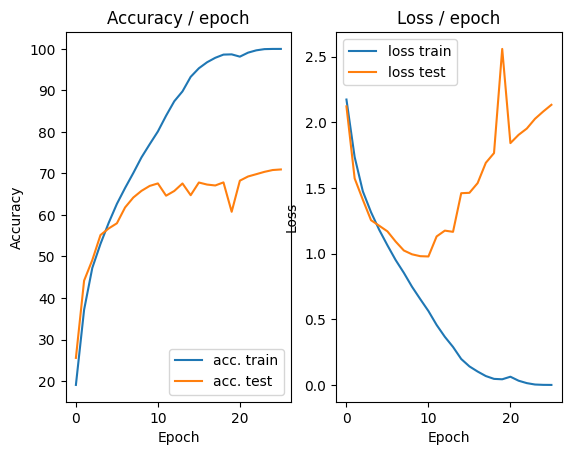

=== EPOCH 27 =====

[TRAIN Batch 000/352]	Time 0.485s (0.485s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


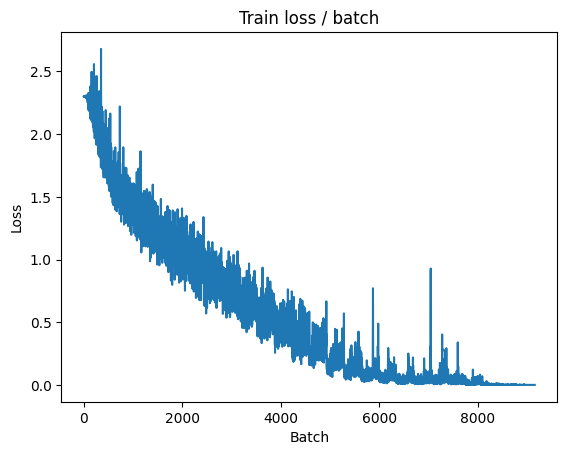

[TRAIN Batch 200/352]	Time 0.060s (0.030s)	Loss 0.0084 (0.0005)	Prec@1  99.2 (100.0)	Prec@5 100.0 (100.0)


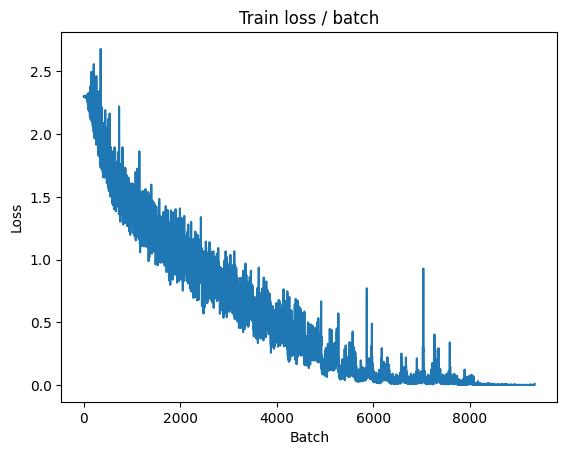


===============> Total time 9s	Avg loss 0.0005	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.169s (0.169s)	Loss 1.9438 (1.9438)	Prec@1  73.4 ( 73.4)	Prec@5  98.4 ( 98.4)

===============> Total time 0s	Avg loss 2.0705	Avg Prec@1 72.30 %	Avg Prec@5 97.54 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 2.3104 (2.3104)	Prec@1  71.1 ( 71.1)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.1731	Avg Prec@1 71.07 %	Avg Prec@5 97.34 %



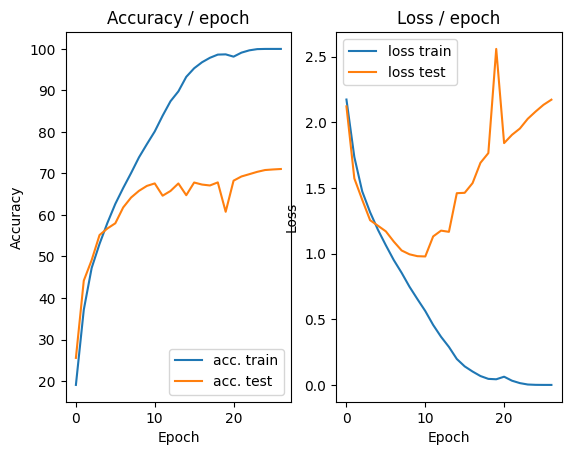

=== EPOCH 28 =====

[TRAIN Batch 000/352]	Time 0.265s (0.265s)	Loss 0.0005 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


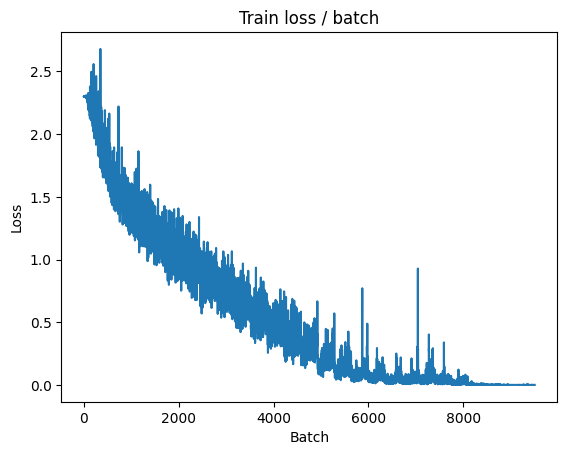

[TRAIN Batch 200/352]	Time 0.038s (0.023s)	Loss 0.0003 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


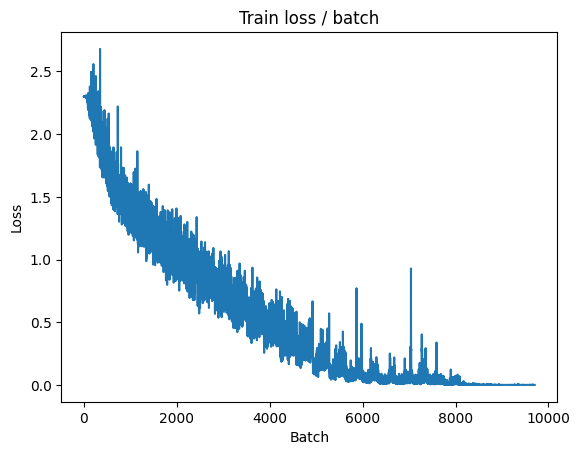


===============> Total time 9s	Avg loss 0.0004	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.164s (0.164s)	Loss 1.6713 (1.6713)	Prec@1  77.3 ( 77.3)	Prec@5  97.7 ( 97.7)

===============> Total time 0s	Avg loss 2.0651	Avg Prec@1 72.44 %	Avg Prec@5 97.54 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 2.3583 (2.3583)	Prec@1  71.9 ( 71.9)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.2053	Avg Prec@1 71.07 %	Avg Prec@5 97.37 %



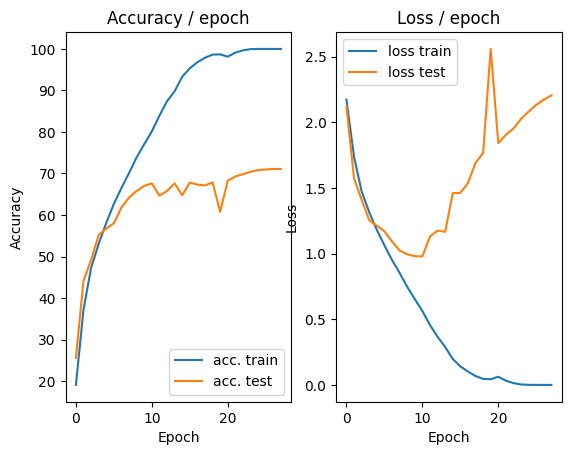

=== EPOCH 29 =====

[TRAIN Batch 000/352]	Time 0.502s (0.502s)	Loss 0.0004 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


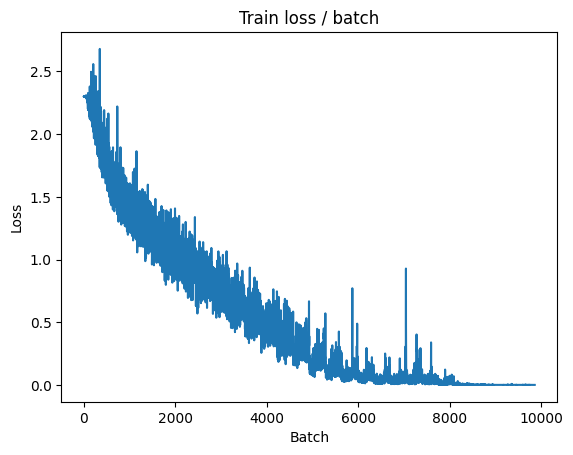

[TRAIN Batch 200/352]	Time 0.019s (0.024s)	Loss 0.0004 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


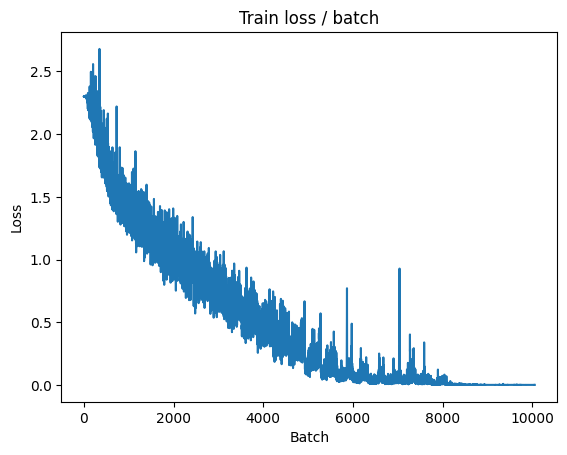


===============> Total time 9s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.216s (0.216s)	Loss 1.7384 (1.7384)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.0995	Avg Prec@1 73.12 %	Avg Prec@5 97.50 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 2.3877 (2.3877)	Prec@1  72.7 ( 72.7)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.2367	Avg Prec@1 71.15 %	Avg Prec@5 97.35 %



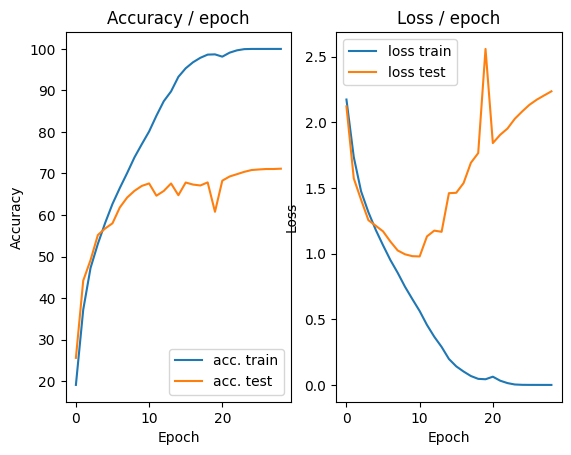

=== EPOCH 30 =====

[TRAIN Batch 000/352]	Time 0.279s (0.279s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


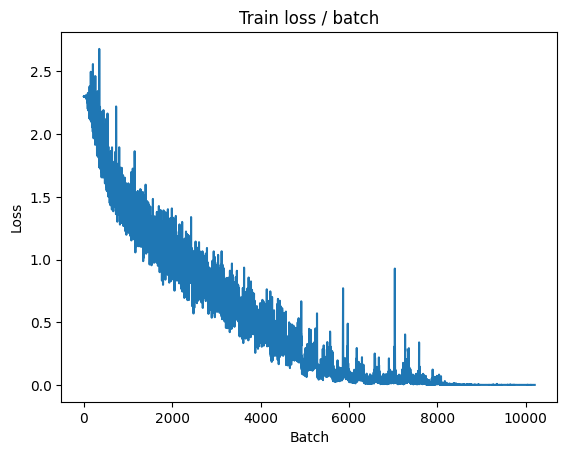

[TRAIN Batch 200/352]	Time 0.017s (0.023s)	Loss 0.0002 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


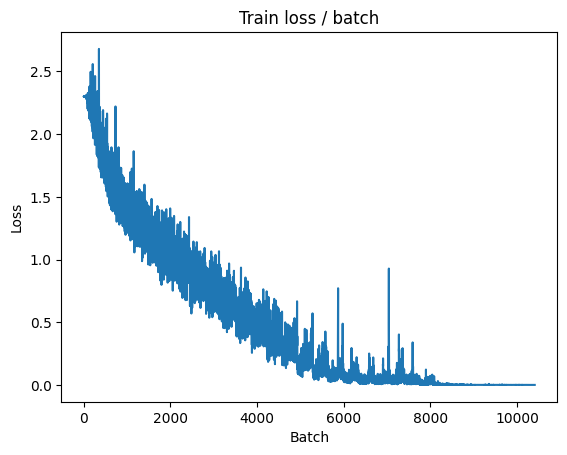


===============> Total time 7s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/040]	Time 0.206s (0.206s)	Loss 1.9281 (1.9281)	Prec@1  72.7 ( 72.7)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.1597	Avg Prec@1 72.48 %	Avg Prec@5 97.58 %

[EVAL Batch 000/079]	Time 0.210s (0.210s)	Loss 2.4073 (2.4073)	Prec@1  71.1 ( 71.1)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 2.2584	Avg Prec@1 71.14 %	Avg Prec@5 97.38 %



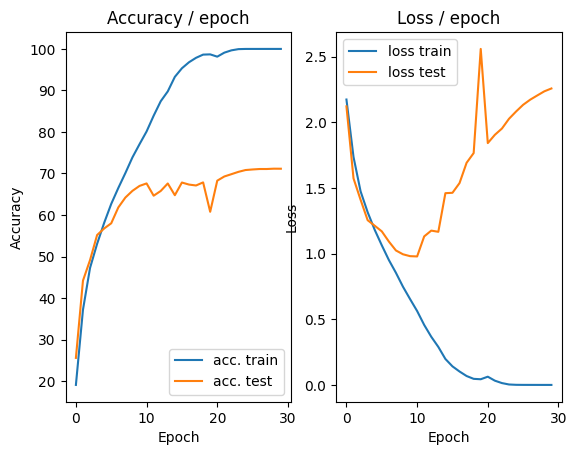

In [ ]:
main(128, 0.1, epochs=30, cuda=True)